In [2]:
import segmentation_models_pytorch as smp
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchmetrics
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import albumentations as A
import torch.nn.functional as F
import pandas as pd
import nibabel as nib
from tqdm import tqdm

2024-03-18 14:46:43.277263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 14:46:49.864934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Extract dataset

In [3]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/ | head -5

BraTS20_Training_001
BraTS20_Training_002
BraTS20_Training_003
BraTS20_Training_004
BraTS20_Training_005


In [4]:
! ls BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/

BraTS20_Training_001_flair.nii	BraTS20_Training_001_t1.nii
BraTS20_Training_001_seg.nii	BraTS20_Training_001_t2.nii
BraTS20_Training_001_t1ce.nii


In [5]:
root = './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
data = pd.read_csv(os.path.join(root, 'name_mapping.csv'))
data.head(5)

Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_CBICA_AAP_1   Brats18_CBICA_AAP_1                  NaN   
4   HGG   Brats17_CBICA_ABB_1   Brats18_CBICA_ABB_1                  NaN   

  BraTS_2019_subject_ID BraTS_2020_subject_ID  
0   BraTS19_CBICA_AAB_1  BraTS20_Training_001  
1   BraTS19_CBICA_AAG_1  BraTS20_Training_002  
2   BraTS19_CBICA_AAL_1  BraTS20_Training_003  
3   BraTS19_CBICA_AAP_1  BraTS20_Training_004  
4   BraTS19_CBICA_ABB_1  BraTS20_Training_005

In [10]:
imgpath = {
    'seg': [],    
    't1': [],
    't1ce': [],
    't2': [],
    'flair': []
}

# load image paths in dictionary
for x in data['BraTS_2020_subject_ID']:
    patient=os.path.join(root,x)
    for name in imgpath:
        imgpath[name].append(os.path.join(patient, x+f'_{name}.nii'))
imgpath['seg'][:5]

['./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_004/BraTS20_Training_004_seg.nii',
 './BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_005/BraTS20_Training_005_seg.nii']

In [11]:
def loadimg(imgpath):
    return nib.load(imgpath).get_fdata()

def cropcentre(imgslice,cropx,cropy):
    y,x = imgslice.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return imgslice[starty:starty+cropy,startx:startx+cropx]

def normalizeslice(imgslice):
    return (imgslice-imgslice.mean()) / imgslice.std()

In [12]:
! mkdir dataset
! mkdir dataset/t1
! mkdir dataset/t1ce
! mkdir dataset/t2
! mkdir dataset/flair
! mkdir dataset/seg

mkdir: cannot create directory ‘dataset’: File exists
mkdir: cannot create directory ‘dataset/t1’: File exists
mkdir: cannot create directory ‘dataset/t1ce’: File exists
mkdir: cannot create directory ‘dataset/t2’: File exists
mkdir: cannot create directory ‘dataset/flair’: File exists
mkdir: cannot create directory ‘dataset/seg’: File exists


In [13]:
numOfImgsSaved = 0
imgs = {}
imgslice = {}
imagestosave = 2000

for i in (range(len(imgpath['seg']))):
    if numOfImgsSaved >= imagestosave:
        break
    for name in imgpath:
        imgs[name] = loadimg(imgpath[name][i])
    
    for j in range(155):
        if numOfImgsSaved >= imagestosave:
            break
        for name in imgs:
            imgslice[name] = imgs[name][:,:,j]
            imgslice[name] = cropcentre(imgslice[name], 192, 192)

        if imgslice['seg'].max() > 0:
            for name in ['t1','t2','t1ce','flair']:
                imgslice[name] = normalizeslice(imgslice[name])
            for name in imgslice:
                np.save(f'./dataset/{name}/img_{numOfImgsSaved}.npy', imgslice[name])
            numOfImgsSaved += 1



In [14]:
! du -h dataset

1.1G	dataset/t1ce
1.1G	dataset/t2
1.1G	dataset/t1
1.1G	dataset/flair
1.1G	dataset/seg
5.5G	dataset


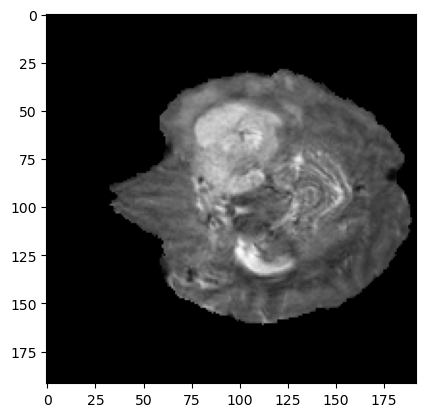

In [15]:
x = np.load('dataset/t2/img_25.npy')
plt.imshow(x, cmap='gray')

# Dataset

In [16]:
class Dataset(Dataset):
    def __init__(self, datapath='./dataset/', augmentation=None):
        self.augmentation = augmentation
        self.folderpaths = {
            'mask': os.path.join(datapath, 'seg/'),
            't1': os.path.join(datapath, 't1/'),
            't1ce': os.path.join(datapath, 't1ce/'),
            't2': os.path.join(datapath, 't2/'),
            'flair': os.path.join(datapath, 'flair/')
        }
    
    def __getitem__(self, idx):
        images = {}
        for name in self.folderpaths:
            images[name] = np.load(os.path.join(self.folderpaths[name], f'img_{idx}.npy'))

        if self.augmentation:
            images = self.augmentation(image=images['flair'],
                                      mask=images['mask'],
                                      t1=images['t1'],
                                      t1ce=images['t1ce'],
                                      t2=images['t2'])
            images['flair'] = images['image']

        for name in images:
            images[name] = torch.from_numpy(images[name])

        # stack modalities
        input = torch.stack([images['t1'],
                             images['t1ce'],
                             images['t2'],
                             images['flair']], dim=0)
        
        # map pixels with value of 4 to 3
        images['mask'][images['mask']==4] = 3

        # one-hot encode truth label
        images['mask'] = F.one_hot(images['mask'].long().unsqueeze(0), num_classes = 4).permute(0,3,1,2).contiguous().squeeze(0)

        return input.float(), images['mask'].long()
    
    def __len__(self):
        return len(os.listdir(self.folderpaths['mask'])) - 1

In [17]:
augmentation = A.Compose([
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)                  
        ], p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    ], 
    additional_targets={'t1':'image',
                          't1ce':'image',
                          't2':'image'})

valid_test_dataset = Dataset(datapath='./dataset/',
                             augmentation=None)

train_dataset = Dataset(datapath='./dataset/',
                        augmentation=augmentation)

train_length=int(0.6 * len(valid_test_dataset))
valid_length = int(0.2 * len(valid_test_dataset))
test_length = len(valid_test_dataset) - train_length - valid_length

_, valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))

train_dataset, _, _ = torch.utils.data.random_split(train_dataset, (train_length,valid_length,test_length), generator=torch.Generator().manual_seed(42))


train_loader= DataLoader(train_dataset,
                      batch_size=16,
                      shuffle=True)

valid_loader= DataLoader(valid_dataset,
                      batch_size=16,
                      shuffle=False)

test_loader= DataLoader(test_dataset,
                      batch_size=16,
                      shuffle=False)

In [21]:
a,b=next(iter(train_loader))

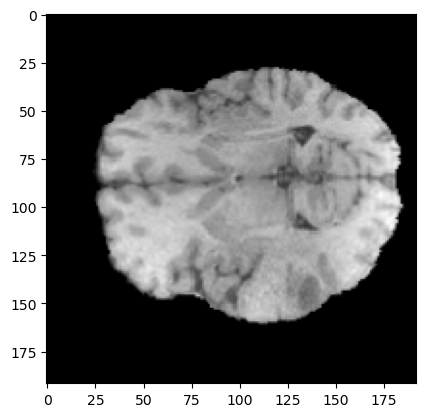

In [22]:
plt.imshow(a[0,0],cmap='gray')

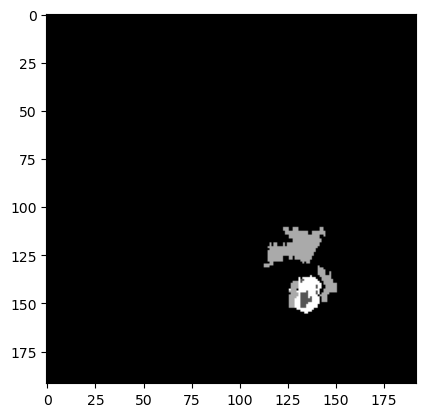

In [23]:
bb = torch.argmax(b,1)
plt.imshow(bb[0],cmap='gray')

# Train Model

In [24]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Mon Mar 18 15:58:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:84:00.0 Off |                  N/A |
| 29%   32C    P8              21W / 250W |   2319MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
        
        self.encoder_block = nn.Sequential(
            # ConvNeXt style blocks
            nn.Conv2d(in_channels,                   in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
            
            nn.Conv2d(out_channels,                 out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels, out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        expansion_ratio = 4
        
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels,                    in_channels, kernel_size=(7,7), stride=1, padding=3, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels,    expansion_ratio*in_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*in_channels,   out_channels, kernel_size=(1,1), stride=1),
            
            nn.Conv2d(out_channels,                  out_channels, kernel_size=(7,7), stride=1, padding=3, groups=out_channels),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,  expansion_ratio*out_channels, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(expansion_ratio*out_channels,  out_channels, kernel_size=(1,1), stride=1),
        )
    def forward(self, x):
        return self.decoder_block(x)
    

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 4   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),

            nn.Conv2d(     8*n_filters,   8*n_filters, kernel_size=(7,7), stride=1, padding=3, groups=8*n_filters),
            nn.BatchNorm2d(8*n_filters),
            nn.Conv2d(     8*n_filters, 4*8*n_filters, kernel_size=(1,1), stride=1),
            activation,
            nn.Conv2d(   4*8*n_filters,   8*n_filters, kernel_size=(1,1), stride=1),
        )
        
        # Decoder
        self.dec_block_4 = DecoderBlock(8*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock(4*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock(2*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock(1*n_filters, 1*n_filters, activation)
        
        # Output projection
        self.output      = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)
        
        # Bottleneck
        x      = self.bottleneck(x)
        
        # Decoder
        x      = self.upsample(x)
        x      = torch.add(x, skip_4)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_3)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_2)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = torch.add(x, skip_1)  # Skip connection
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x


In [26]:
# Define the loss function
def dice_loss(inputs, targets, smooth=1e-5):
    inputs = F.softmax(inputs, dim=1)
    iflat = inputs.contiguous().view(-1)
    tflat = targets.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))

# Define the training loop
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    epoch_loss = 0
    bce_loss = nn.BCEWithLogitsLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_dice = dice_loss(outputs, targets)
        loss_bce = bce_loss(outputs, targets.float())
        loss = 0.5*loss_dice + 0.5*loss_bce
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"\rBatch Loss: {loss.item():.4f}", end="")
    return epoch_loss / len(data_loader)

# Define the validation loop
def validate(model, data_loader, device, num_classes):
    model.eval()
    epoch_loss = 0
    bce_loss = nn.BCEWithLogitsLoss().to(device)
    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            loss_dice = dice_loss(outputs, targets)
            loss_bce = bce_loss(outputs, targets.float())
            loss = 0.5*loss_dice + 0.5*loss_bce
            epoch_loss += loss.item()
            print(f"\rVal Batch Loss: {loss.item():.4f}", end="")

        d_loss = loss_dice.item()
        dice_score = 1 - d_loss
    return epoch_loss / len(data_loader), dice_score

# Training and validation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_classes = 4

stats = {
    'train_loss': [],
    'valid_loss': [],
    'dice_score': []
}

for epoch in range(20):
    print(f'\n --- Epoch {epoch} --- ')

    # Training
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    print(f'Train Loss: {train_loss:.4f}')

    # Validation
    valid_loss, dice_score = validate(model, valid_loader, device, num_classes)
    print(f'Valid Loss: {valid_loss:.4f}, Dice Score: {dice_score:.4f}')

    # Update statistics
    stats['train_loss'].append(train_loss)
    stats['valid_loss'].append(valid_loss)
    stats['dice_score'].append(dice_score)

np.save('./model.npy', stats)



 --- Epoch 0 --- 
Batch Loss: 0.5073Train Loss: 0.6740
Val Batch Loss: 0.4880Valid Loss: 0.4848, Dice Score: 0.4802

 --- Epoch 1 --- 
Batch Loss: 0.1521Train Loss: 0.3039
Val Batch Loss: 0.1547Valid Loss: 0.1487, Dice Score: 0.8787

 --- Epoch 2 --- 
Batch Loss: 0.0696Train Loss: 0.0984
Val Batch Loss: 0.0749Valid Loss: 0.0679, Dice Score: 0.9477

 --- Epoch 3 --- 
Batch Loss: 0.0496Train Loss: 0.0585
Val Batch Loss: 0.0564Valid Loss: 0.0489, Dice Score: 0.9574

 --- Epoch 4 --- 
Batch Loss: 0.0423Train Loss: 0.0464
Val Batch Loss: 0.0474Valid Loss: 0.0405, Dice Score: 0.9607

 --- Epoch 5 --- 
Batch Loss: 0.0373Train Loss: 0.0399
Val Batch Loss: 0.0418Valid Loss: 0.0352, Dice Score: 0.9632

 --- Epoch 6 --- 
Batch Loss: 0.0287Train Loss: 0.0365
Val Batch Loss: 0.0357Valid Loss: 0.0312, Dice Score: 0.9687

 --- Epoch 7 --- 
Batch Loss: 0.0291Train Loss: 0.0317
Val Batch Loss: 0.0269Valid Loss: 0.0248, Dice Score: 0.9784

 --- Epoch 8 --- 
Batch Loss: 0.0289Train Loss: 0.0273
Val Batc

Text(0.5, 1.0, 'Train and Validation Loss')

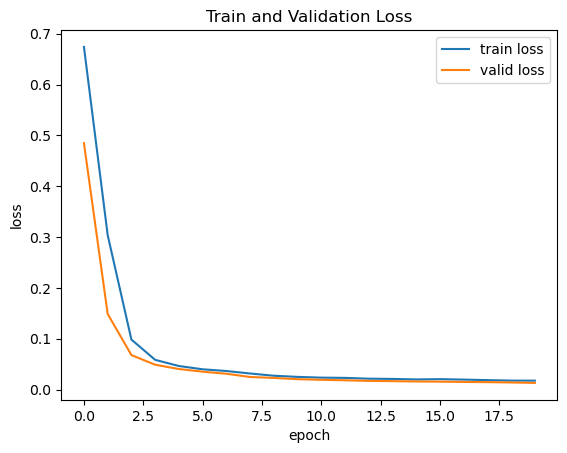

In [27]:
STATS = np.load(f'./model.npy', allow_pickle='TRUE').item()
plt.plot(STATS['train_loss'], label='train loss')
plt.plot(STATS['valid_loss'], label='valid loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Validation Loss')

Text(0.5, 1.0, 'Dice Score')

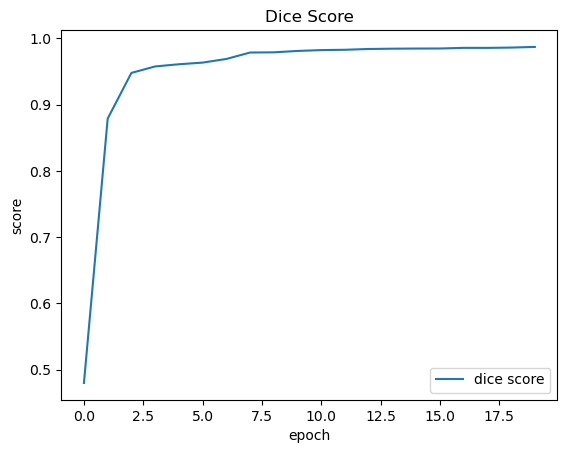

In [28]:
plt.plot(STATS['dice_score'], label='dice score')
plt.legend(loc="lower right")
plt.ylabel('score')
plt.xlabel('epoch')
plt.title('Dice Score')

In [29]:
a,b=next(iter(train_loader))
outputs = model(a.cuda())
predicted_mask = torch.sigmoid(outputs)
predicted_mask_cpu = predicted_mask.cpu().detach().numpy()

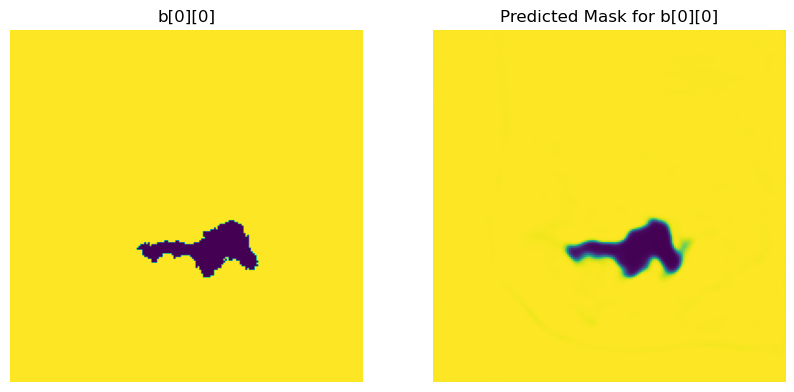

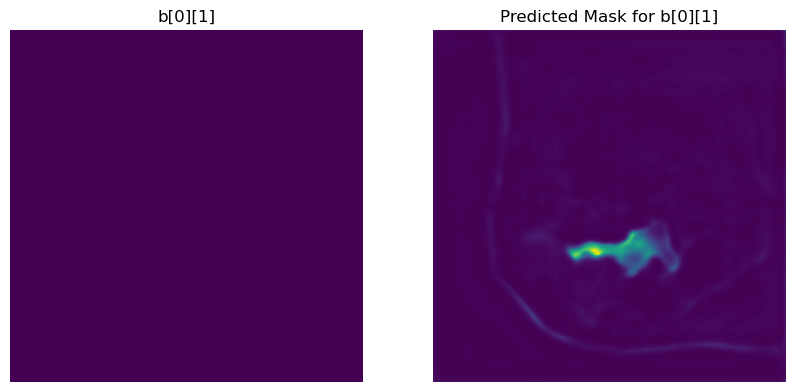

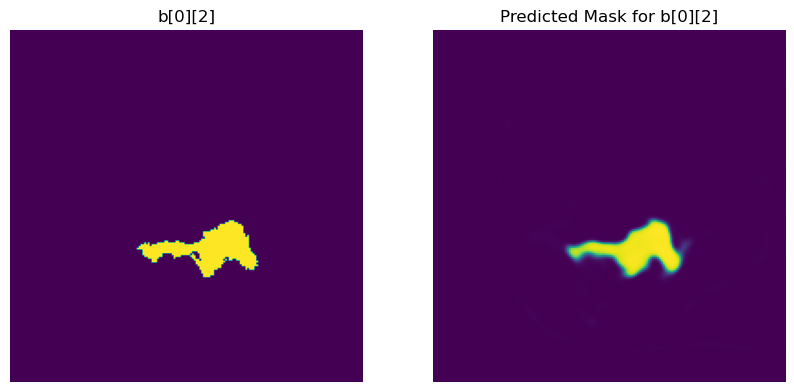

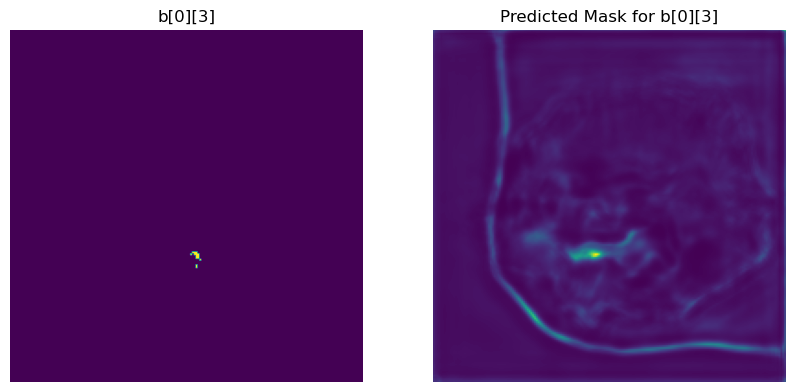

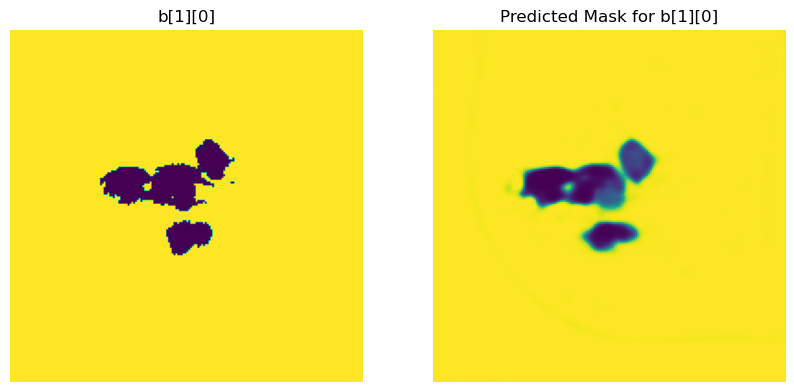

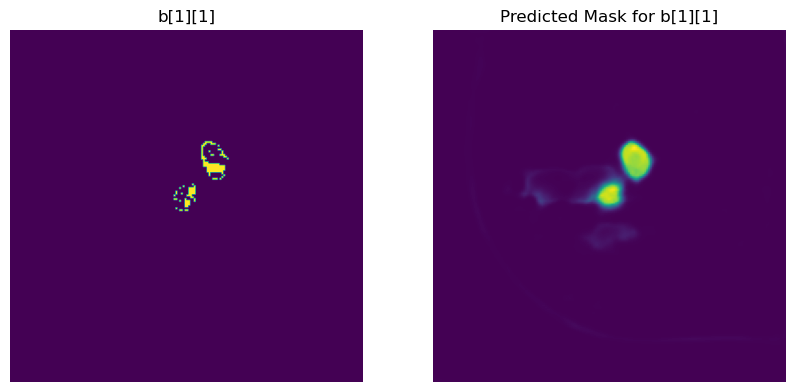

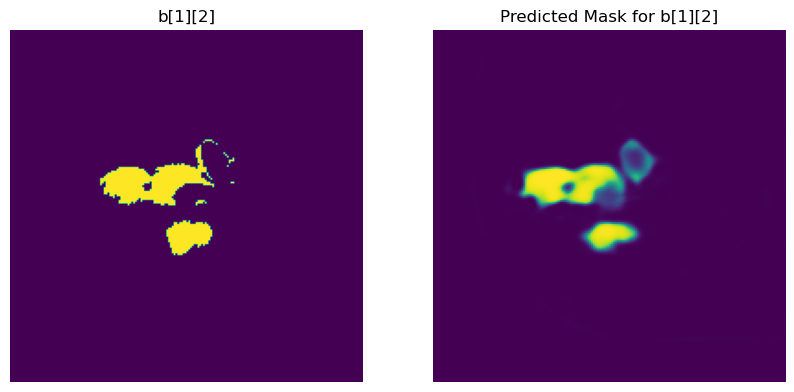

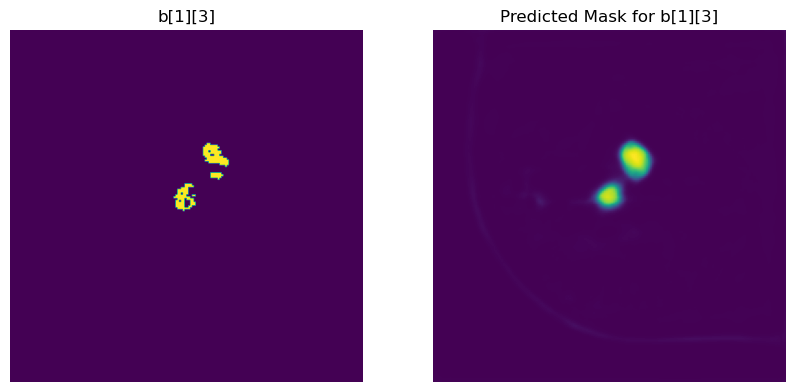

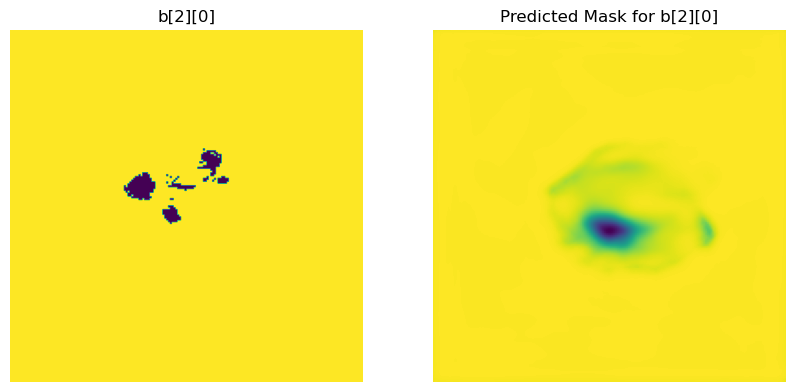

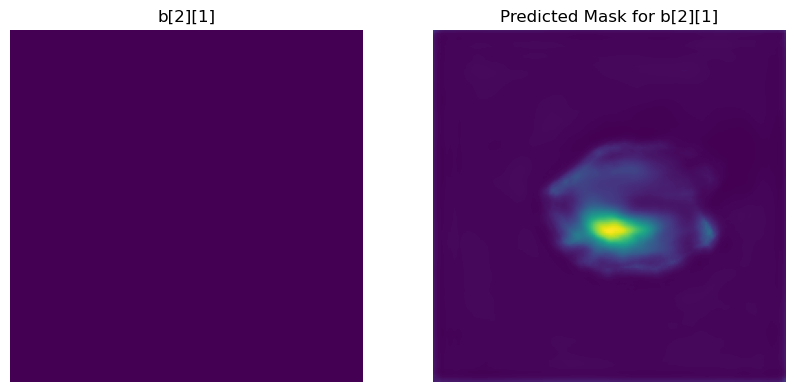

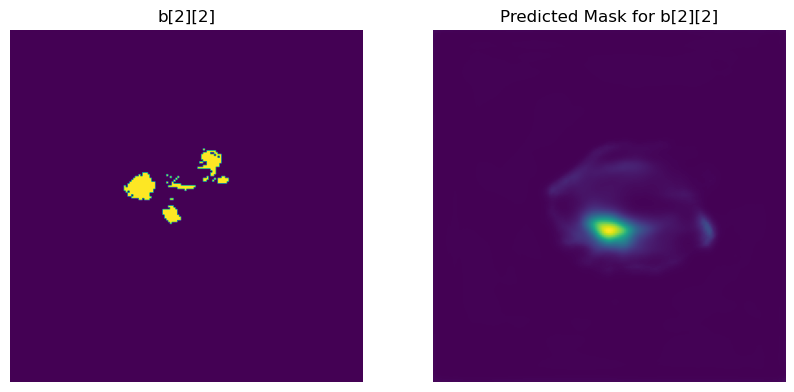

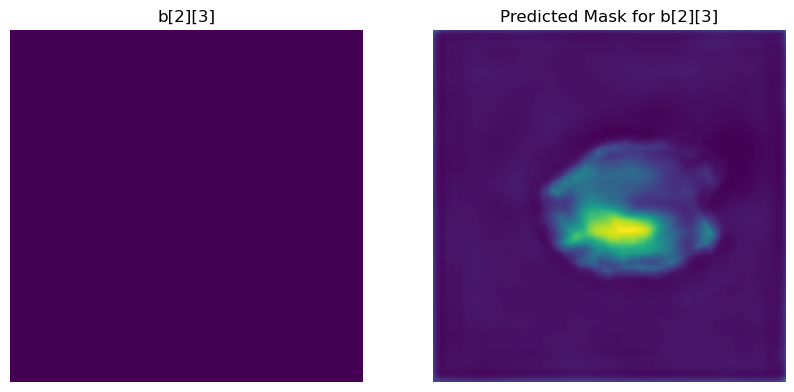

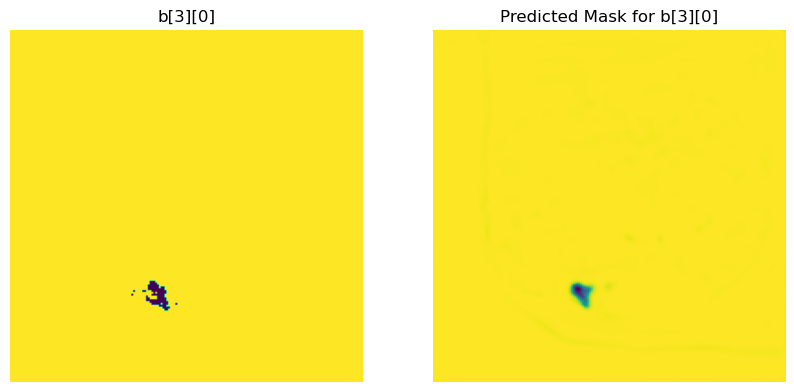

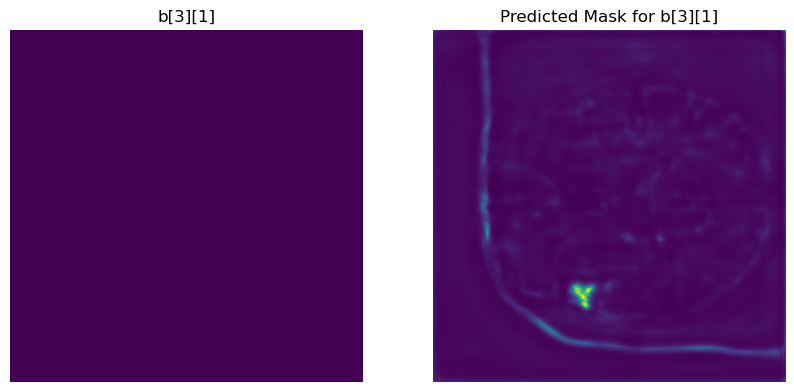

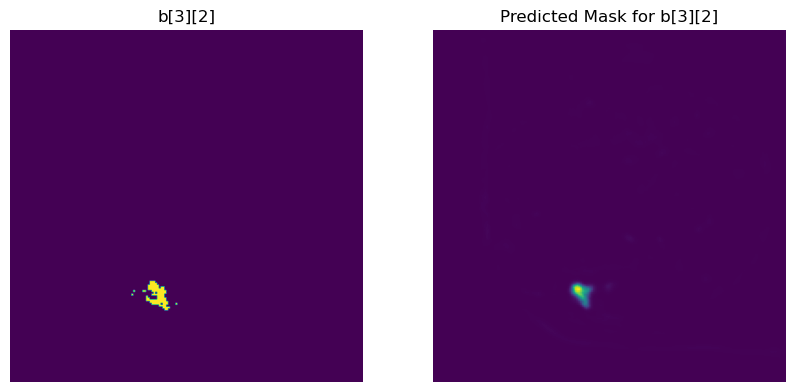

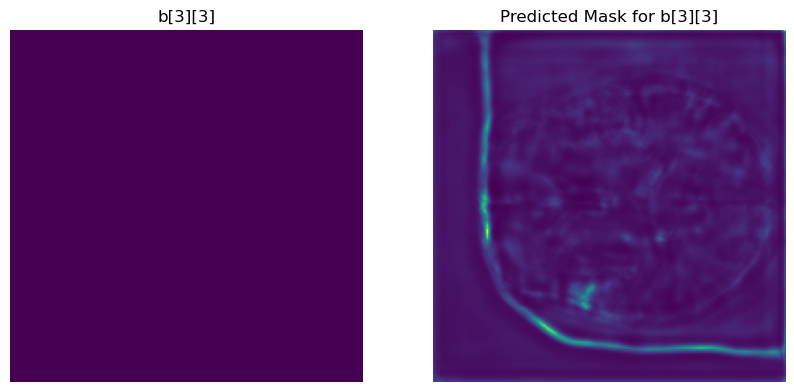

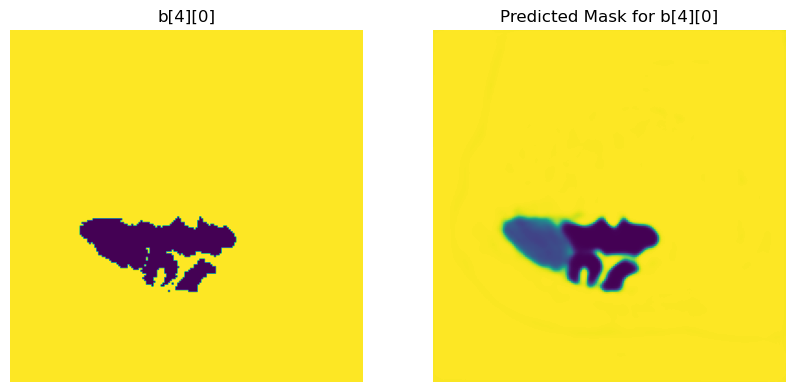

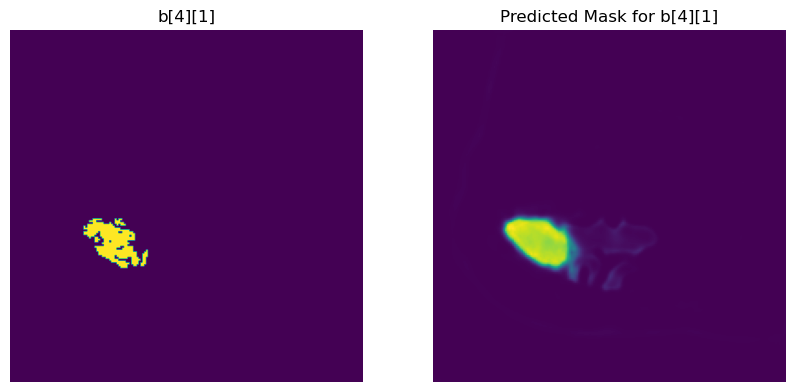

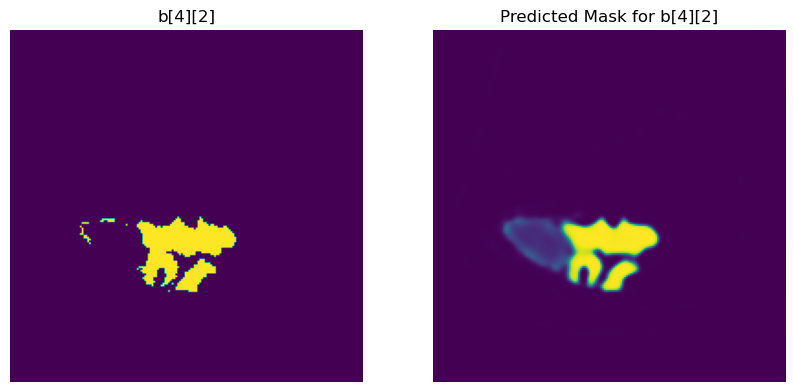

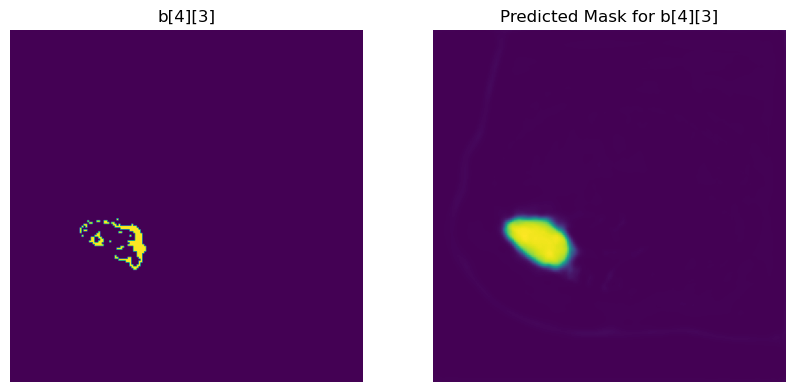

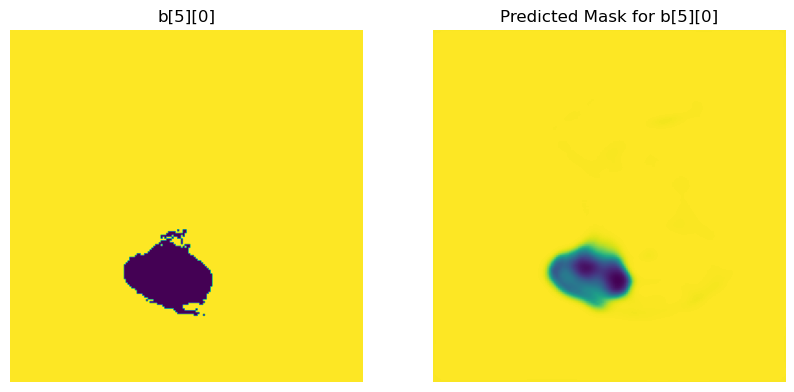

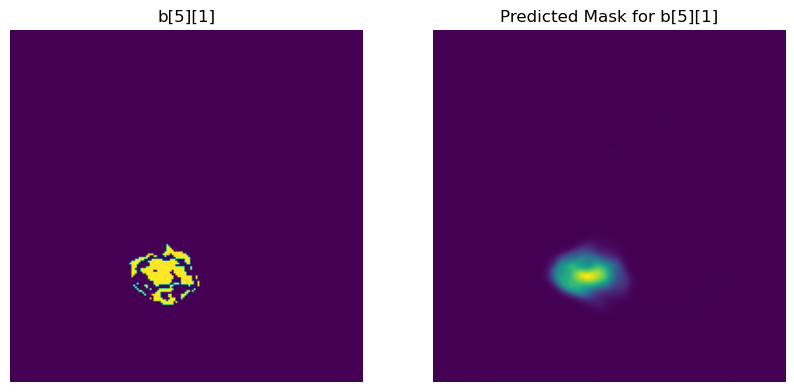

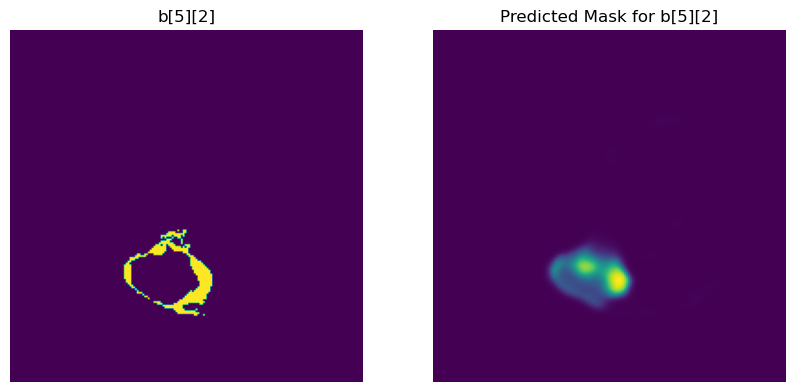

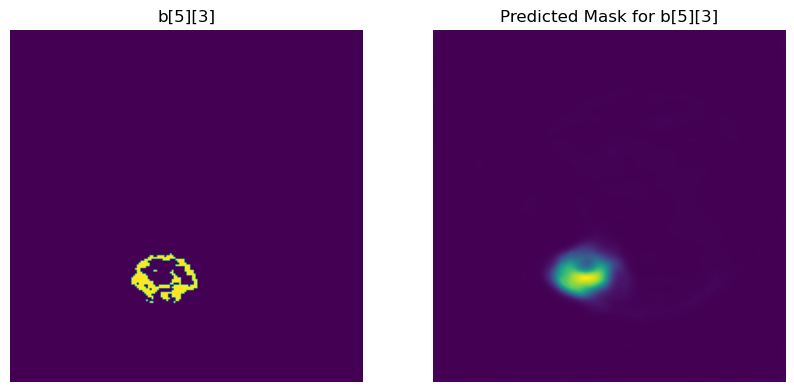

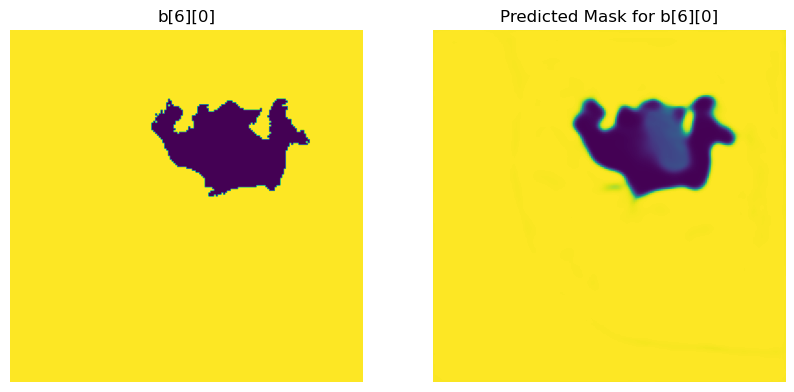

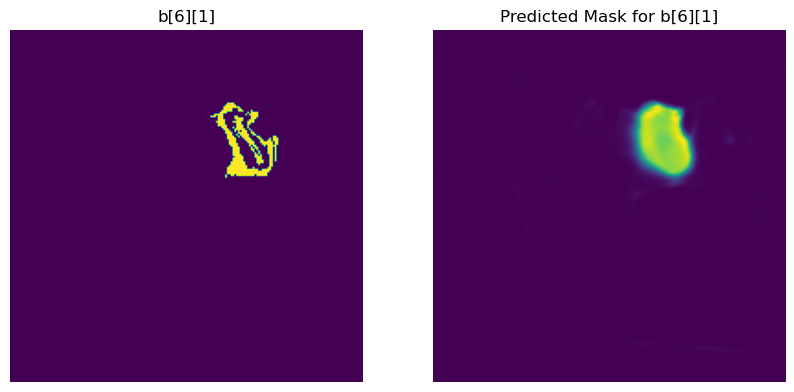

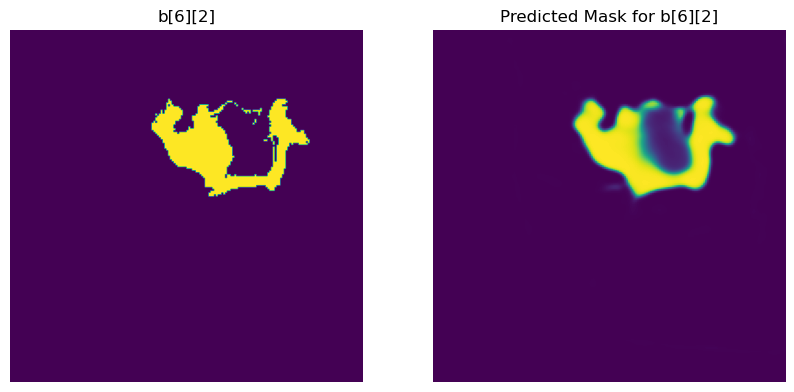

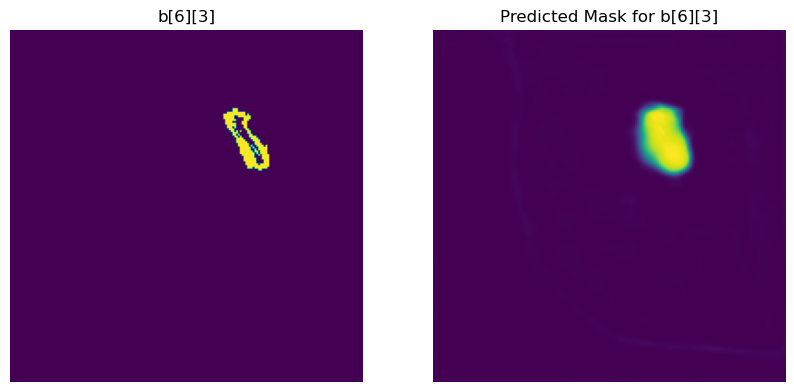

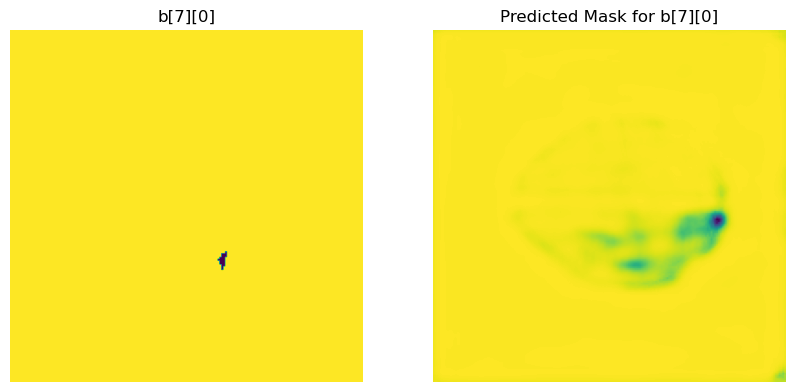

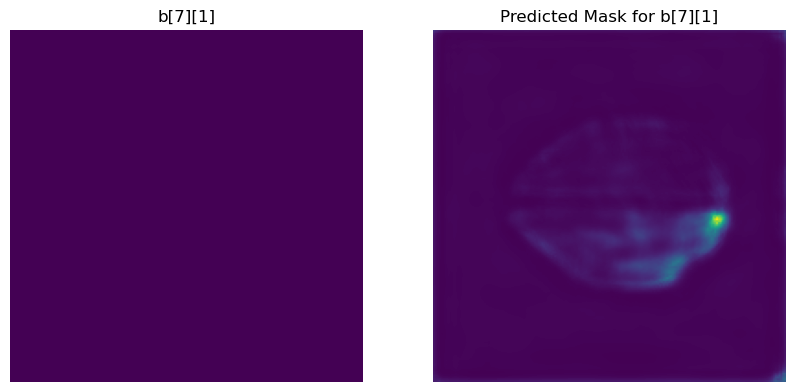

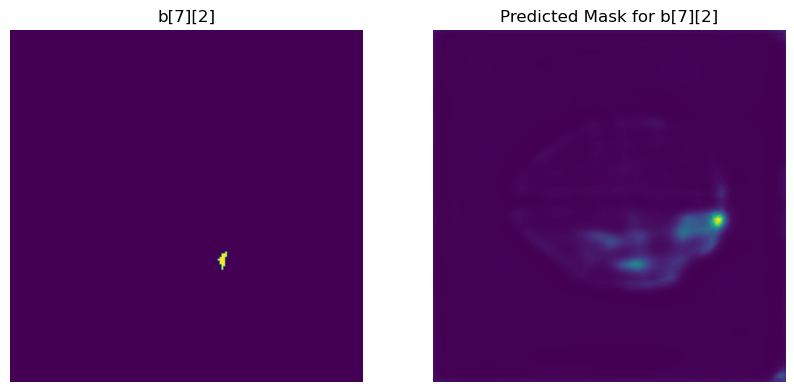

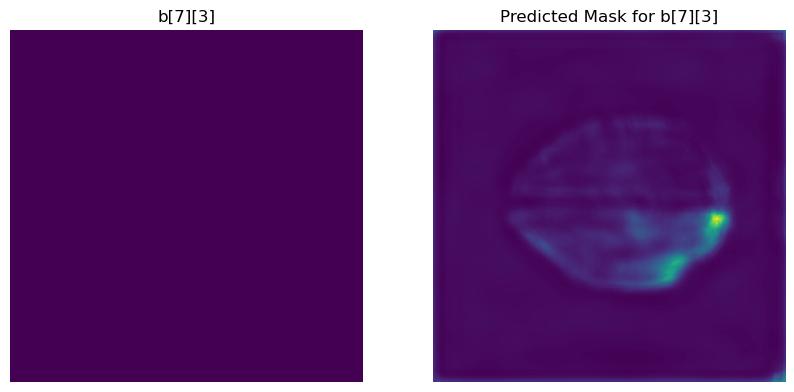

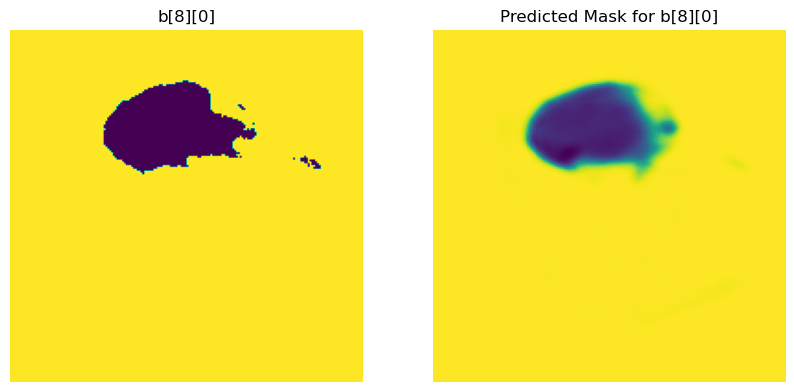

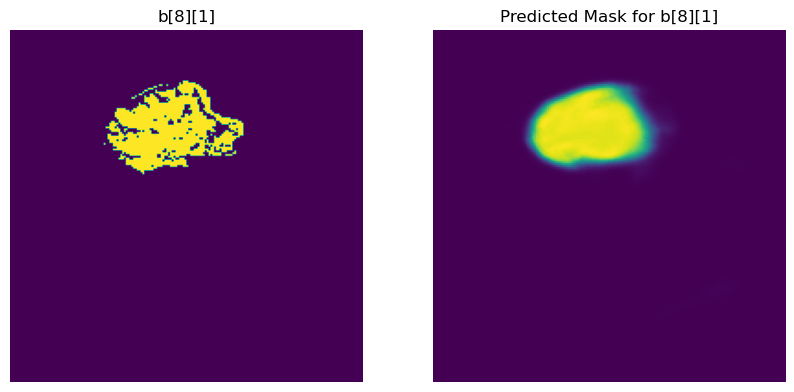

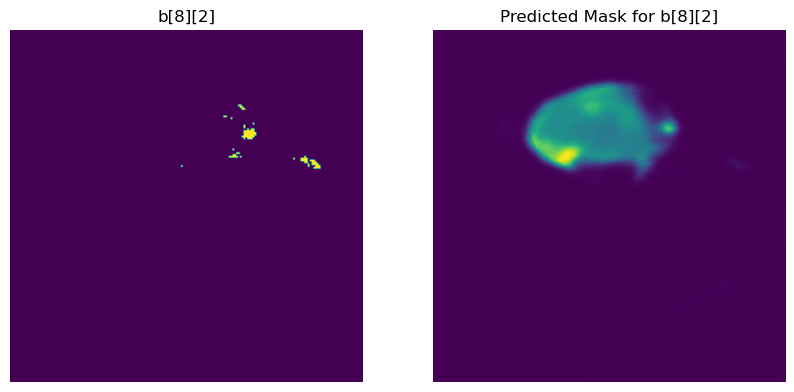

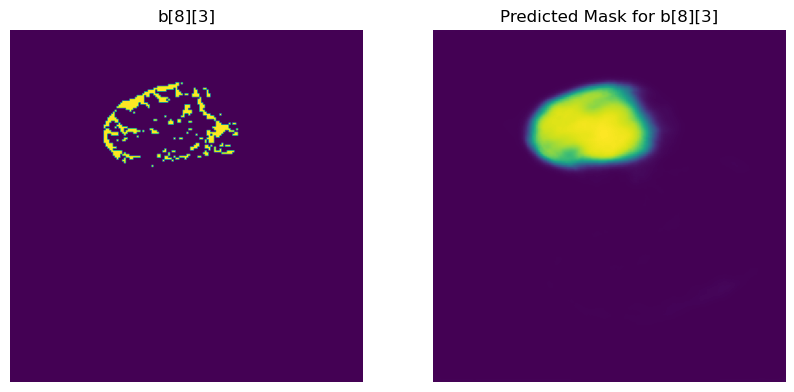

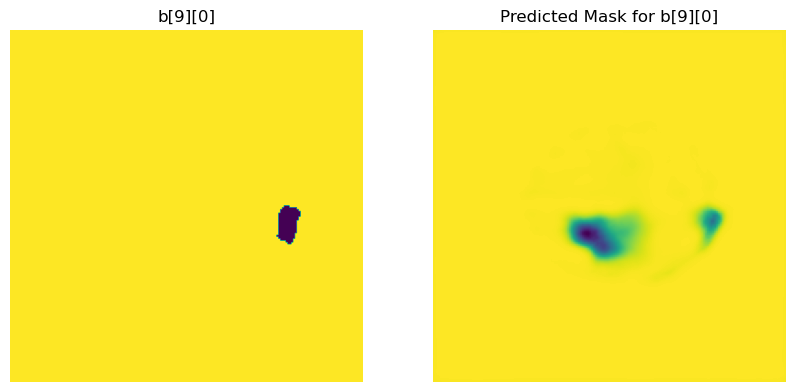

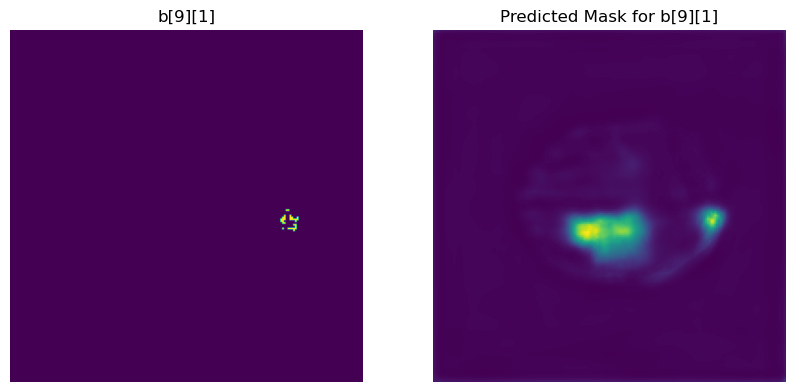

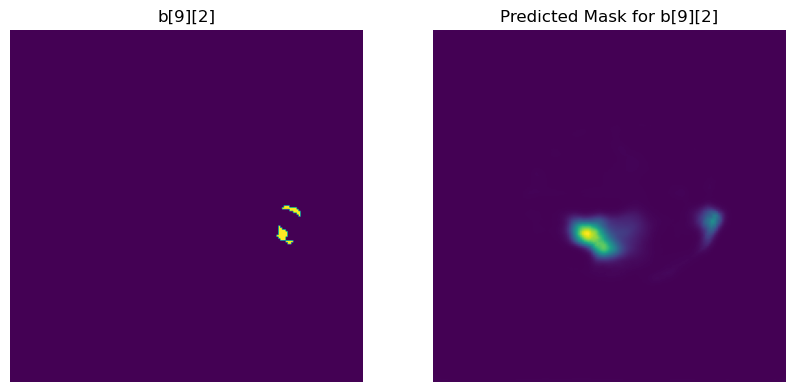

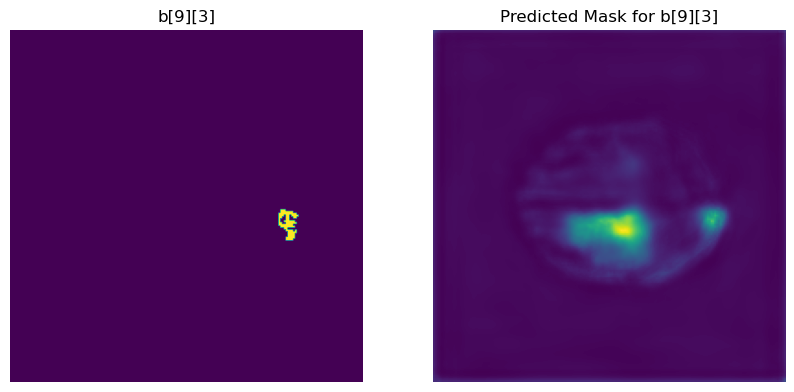

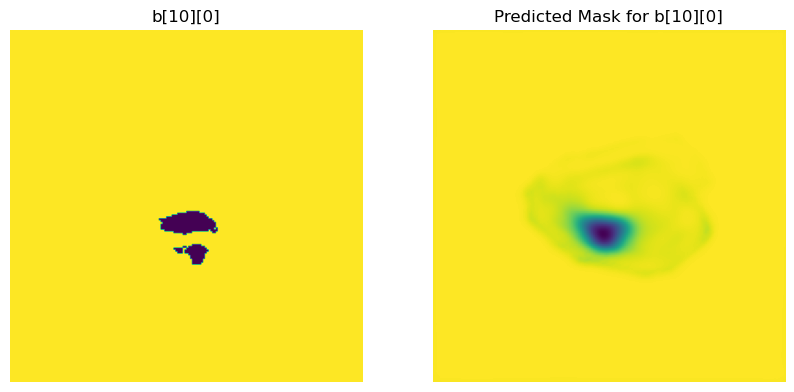

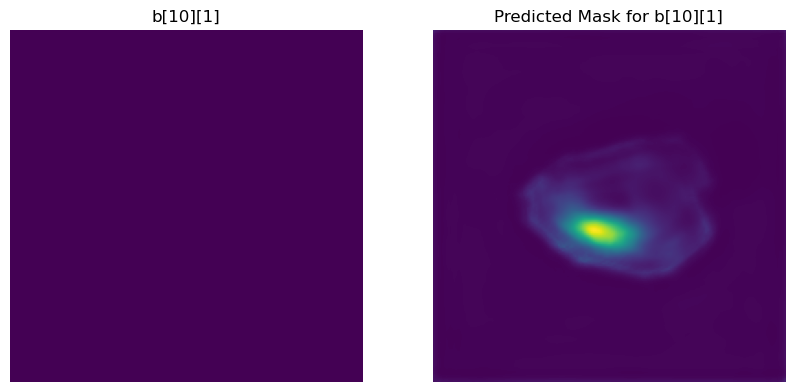

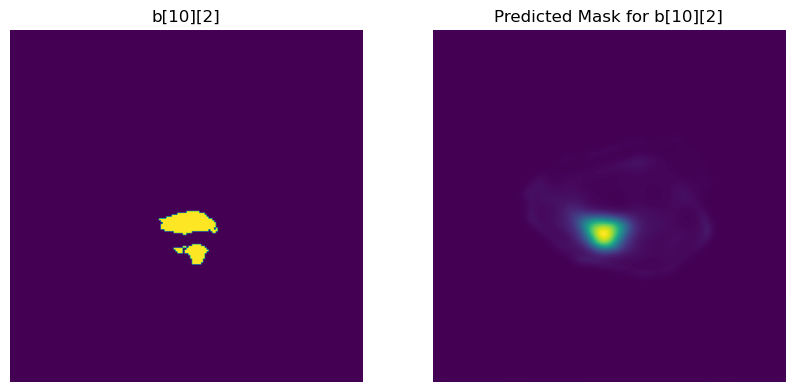

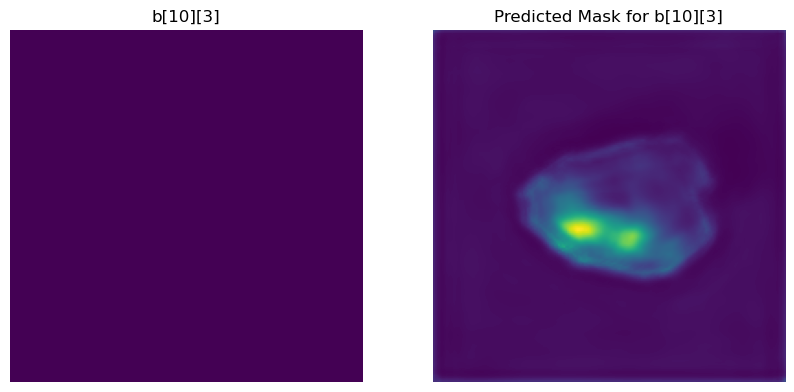

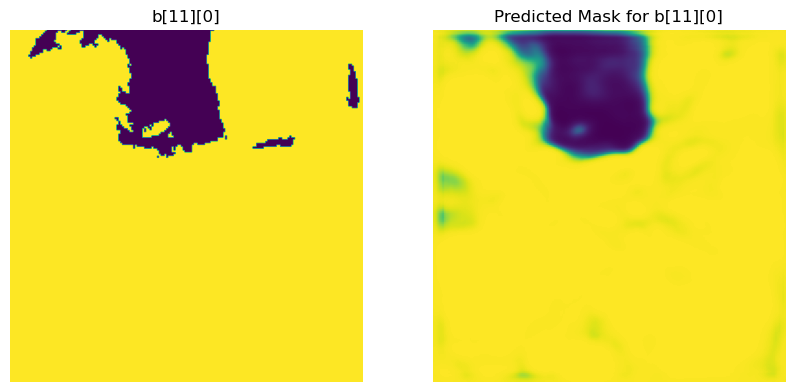

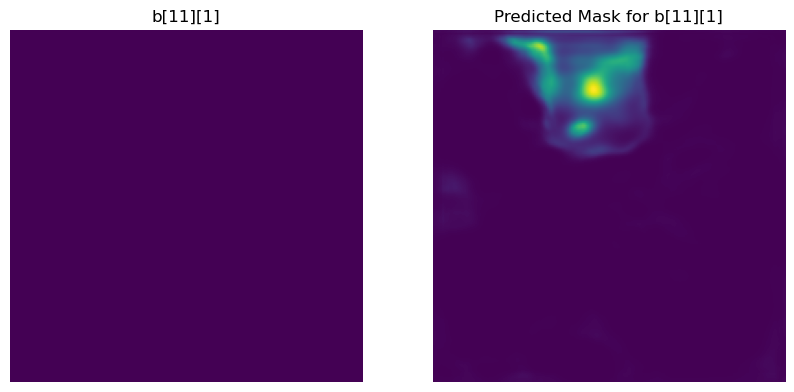

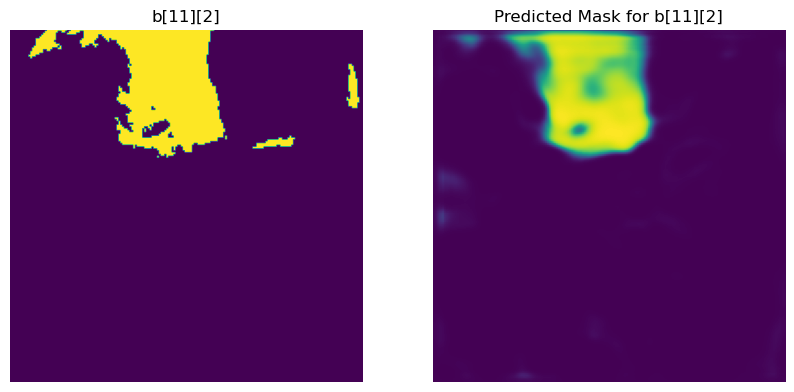

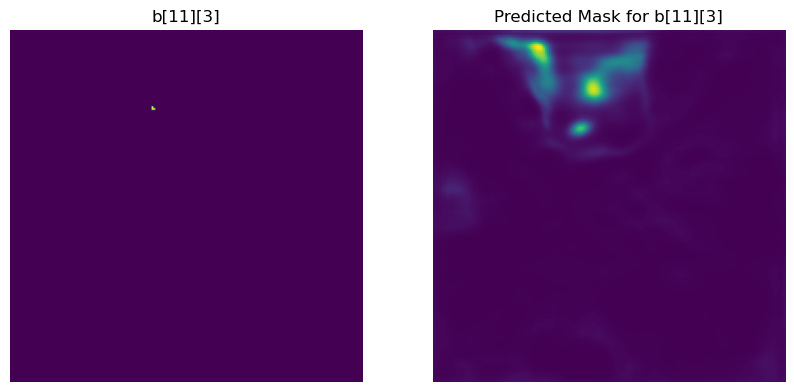

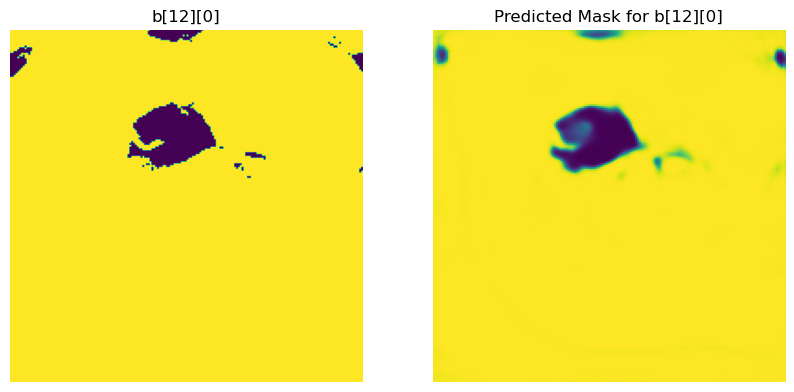

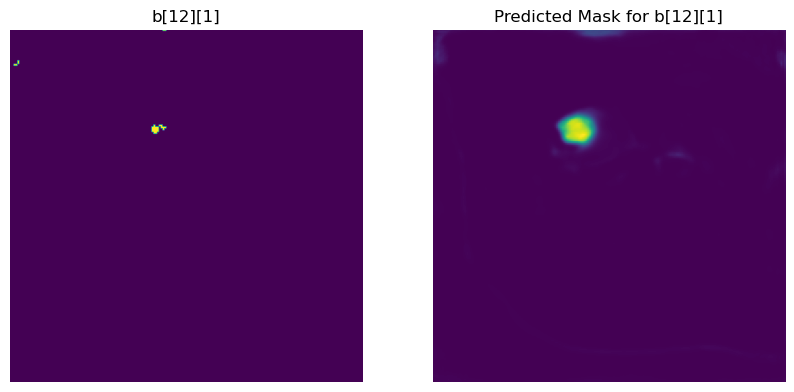

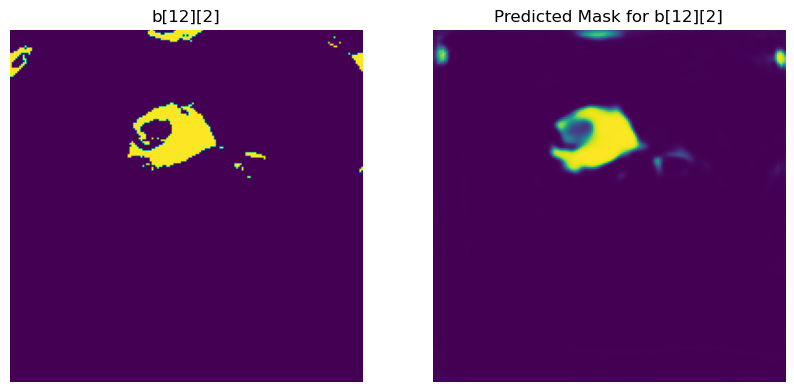

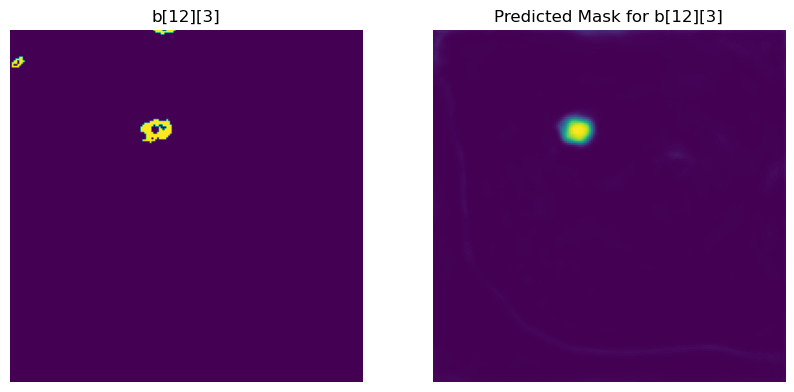

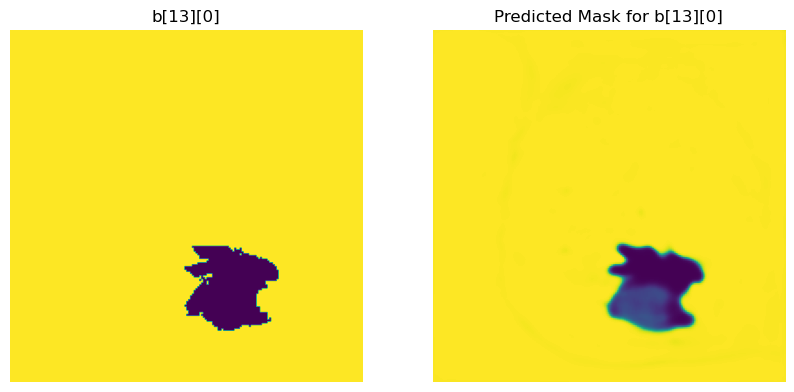

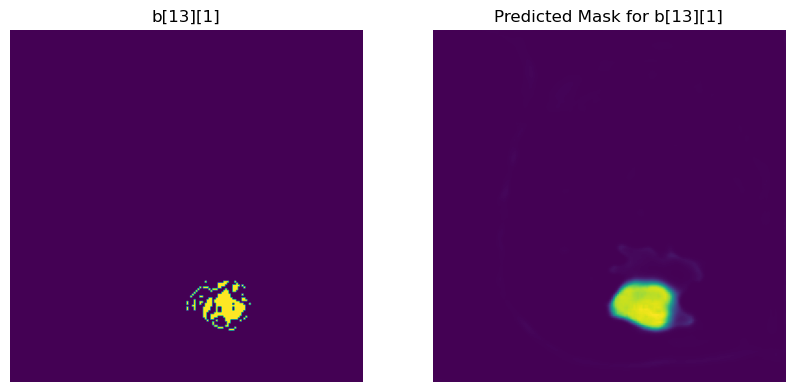

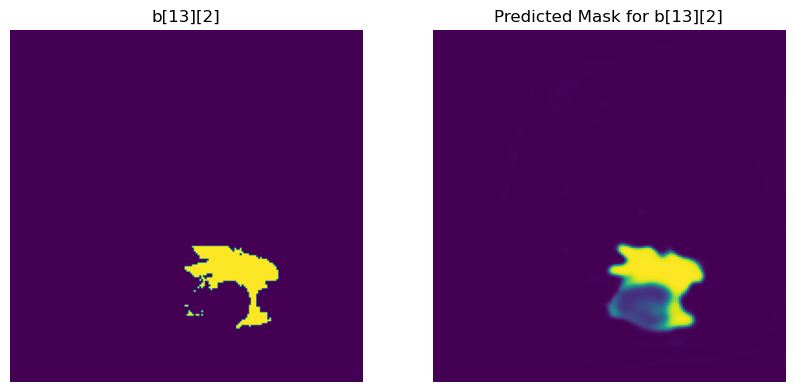

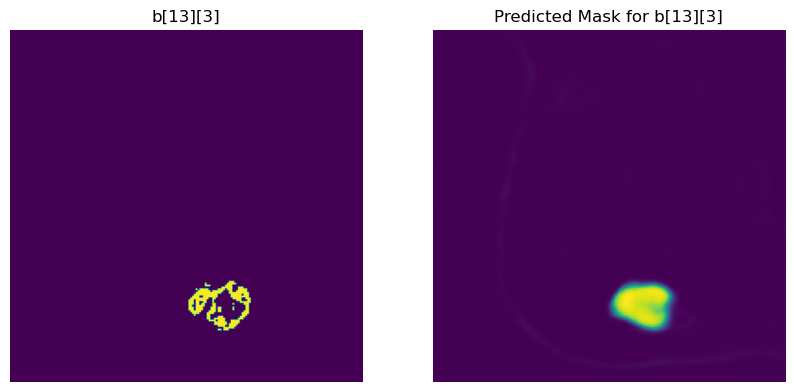

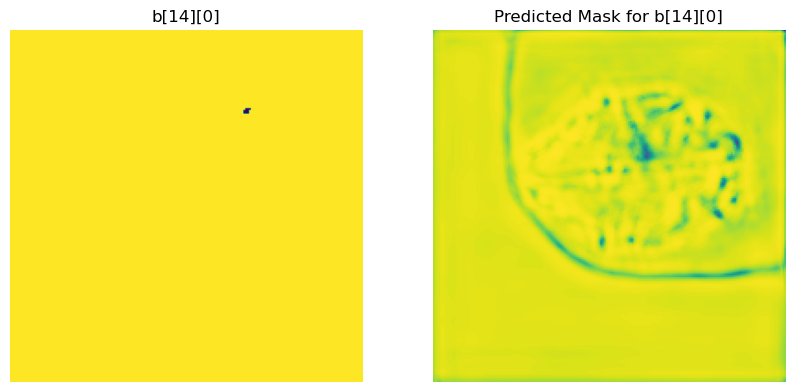

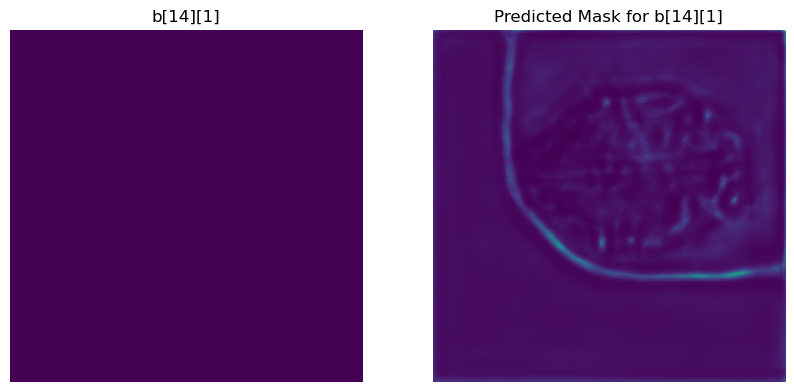

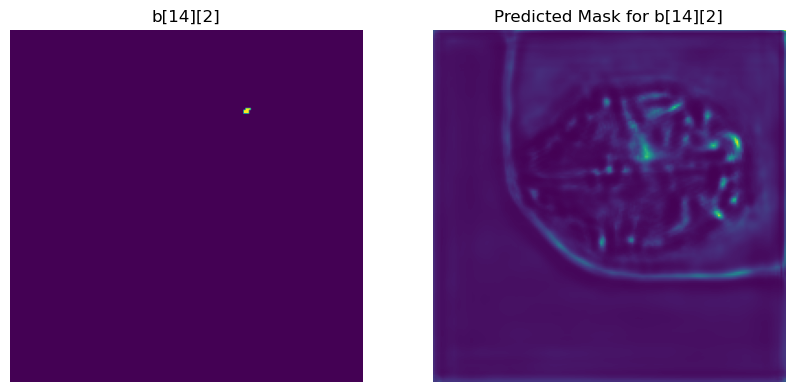

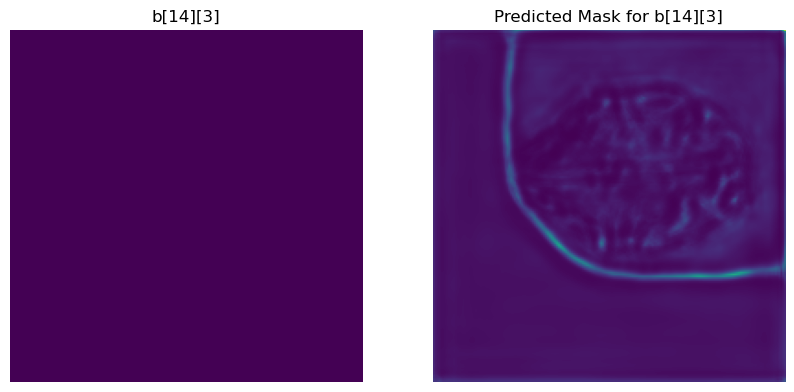

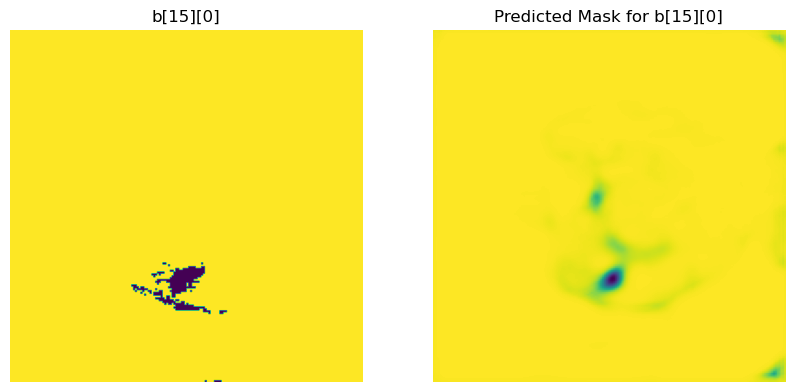

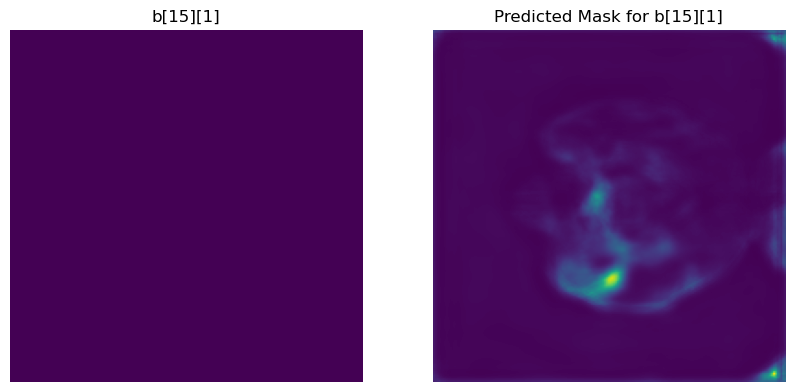

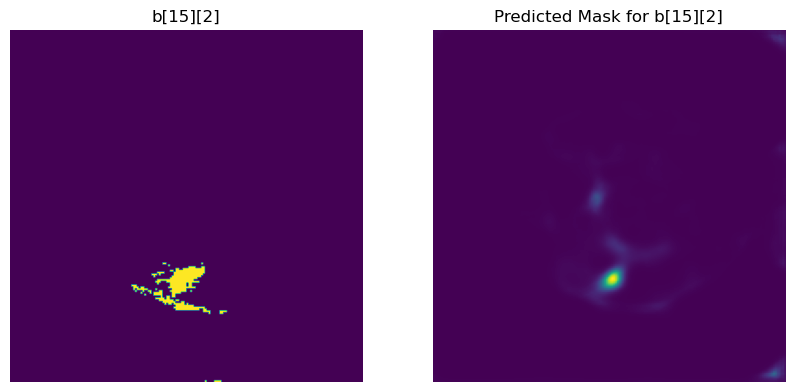

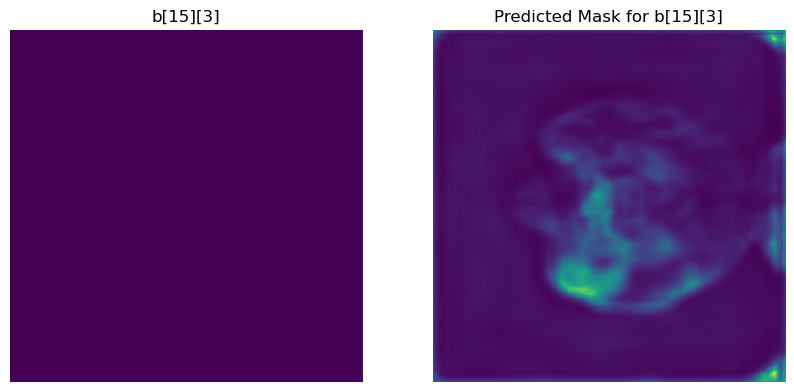

In [30]:
for i in range(len(b)):
    for j in range(len(b[i])):
        plt.figure(figsize=(10, 5))

        # Plot b[i][j]
        plt.subplot(1, 2, 1)
        plt.imshow(b[i][j])
        plt.title(f"b[{i}][{j}]")
        plt.axis('off')

        # Plot predicted_mask_cpu[i][j]
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask_cpu[i][j])
        plt.title(f"Predicted Mask for b[{i}][{j}]")
        plt.axis('off')

        plt.show()


# Test Model

In [31]:
a,b=next(iter(test_loader))
outputs = model(a.cuda())
predicted_mask = torch.sigmoid(outputs)
predicted_mask_cpu = predicted_mask.cpu().detach().numpy()

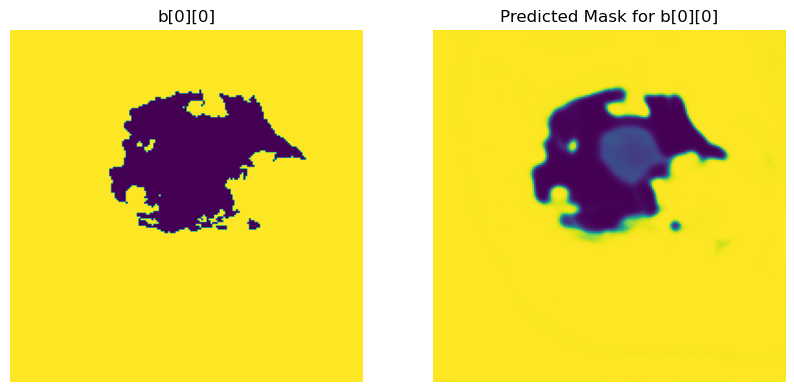

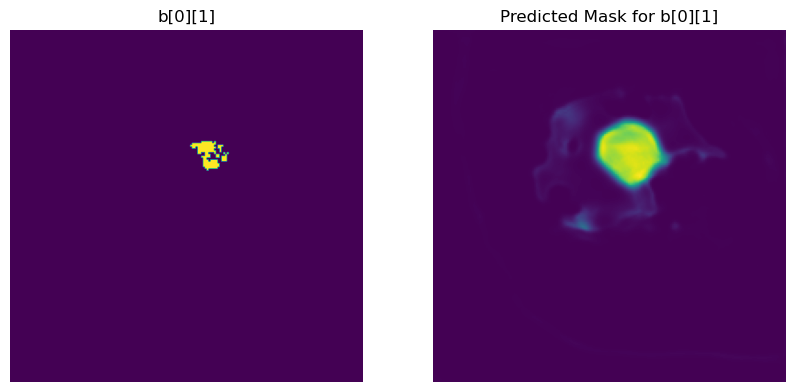

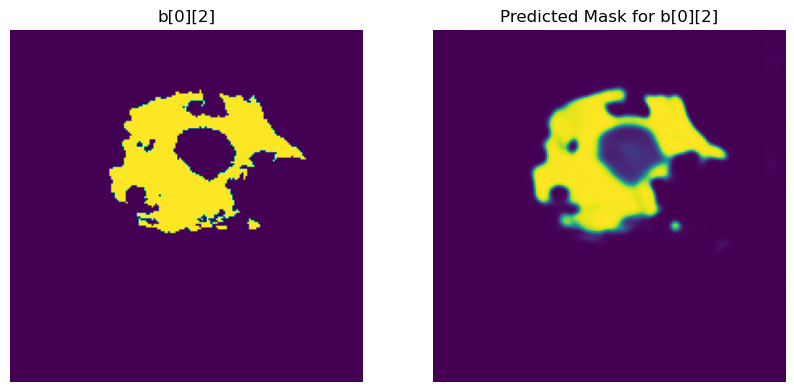

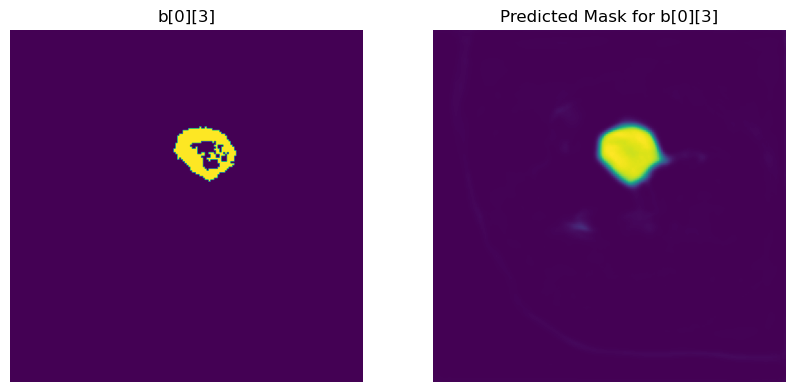

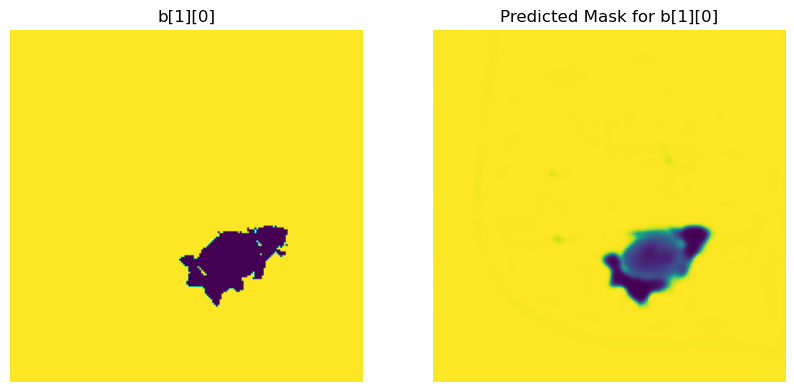

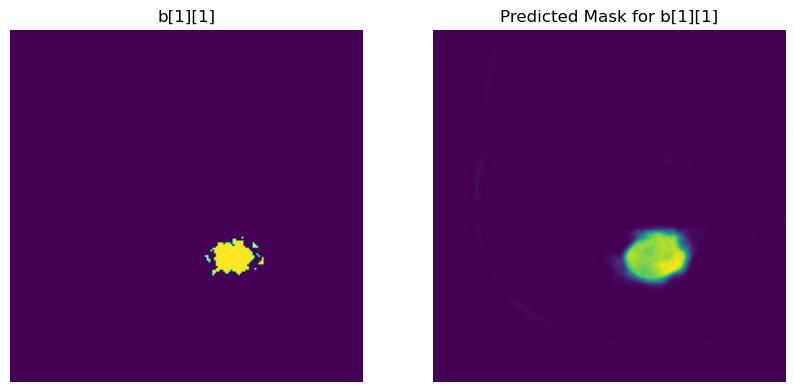

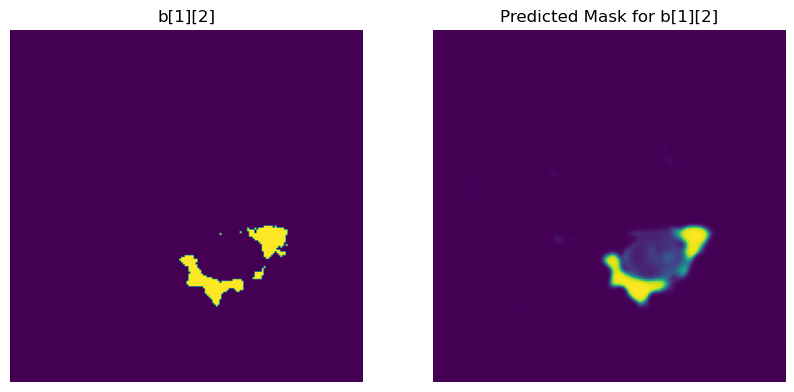

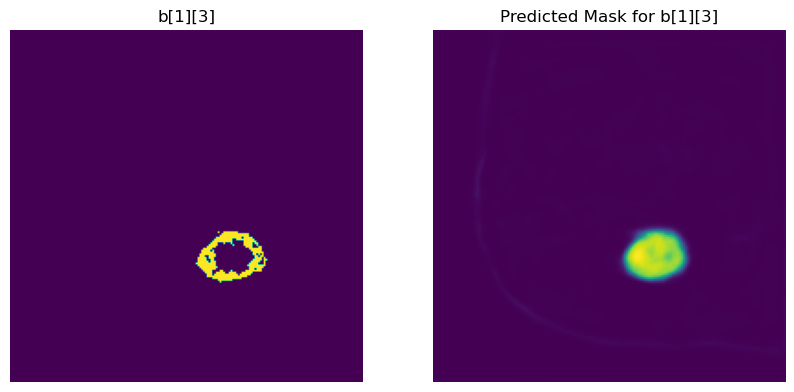

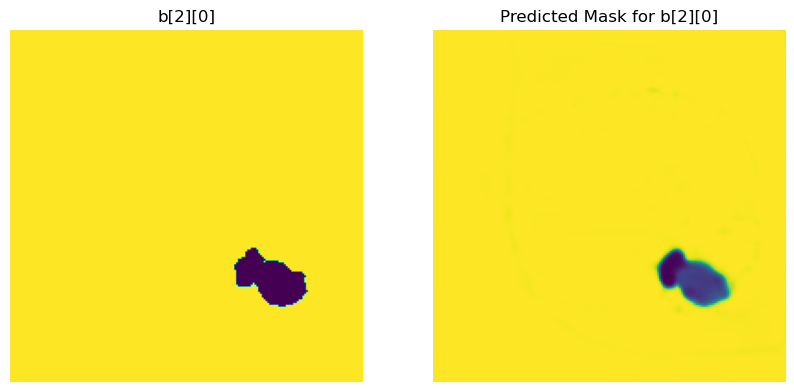

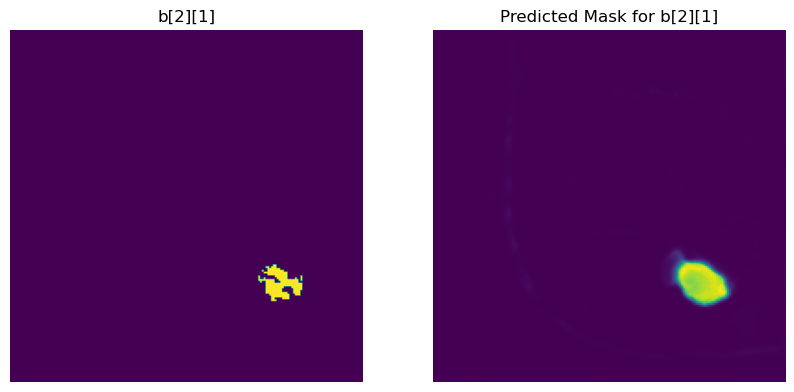

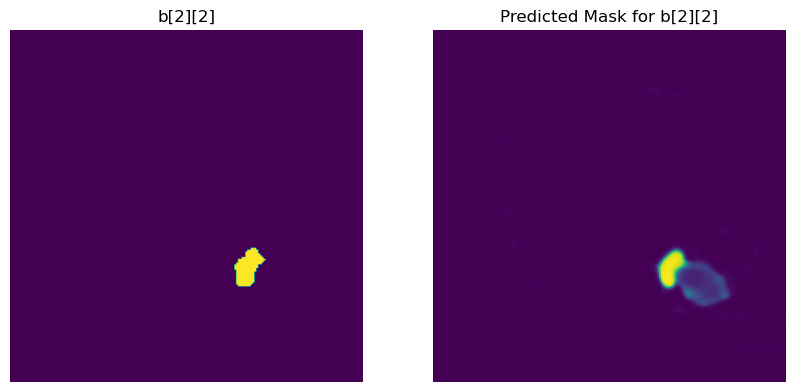

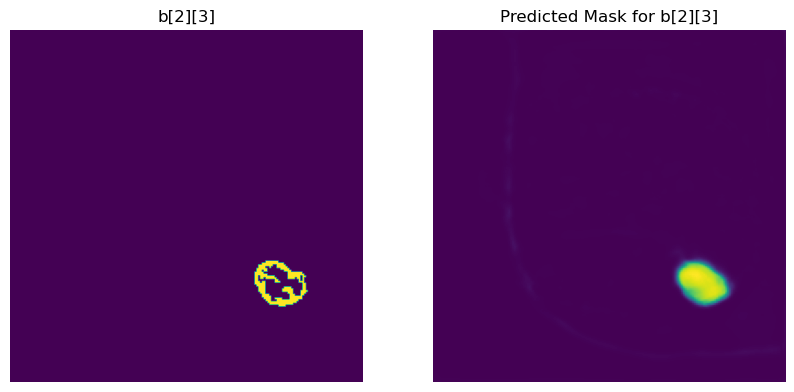

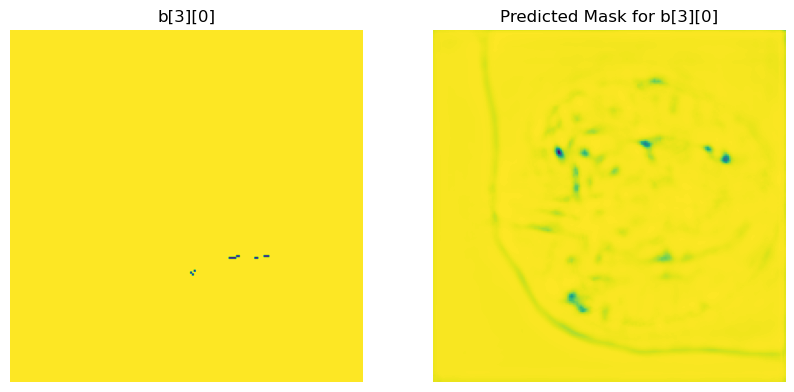

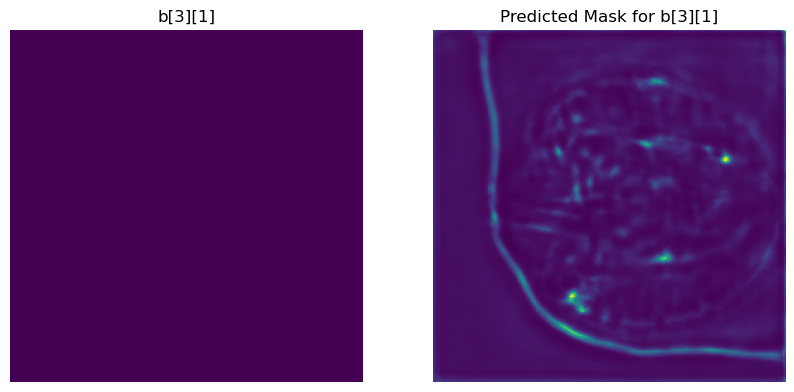

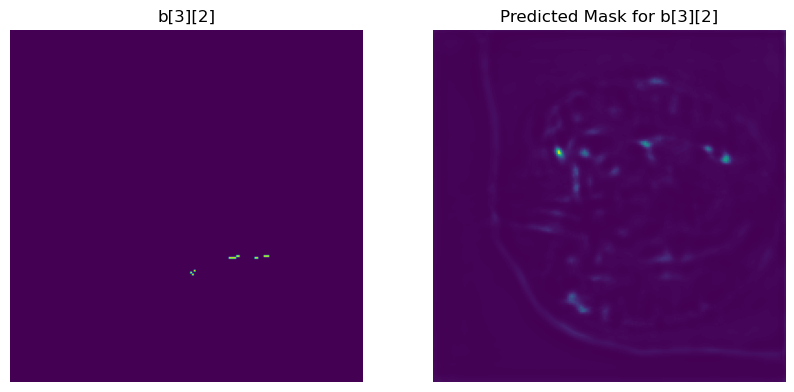

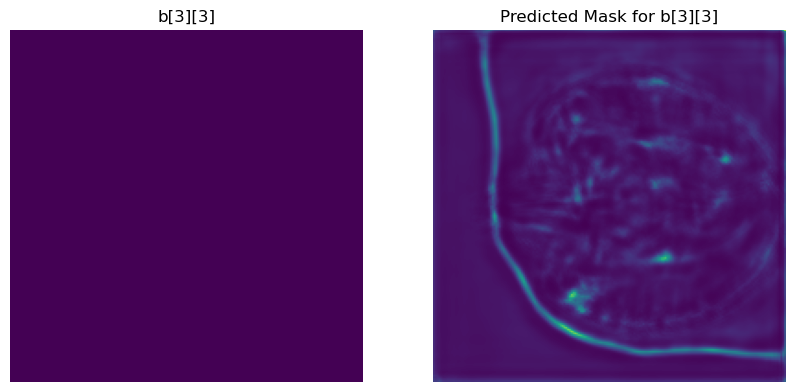

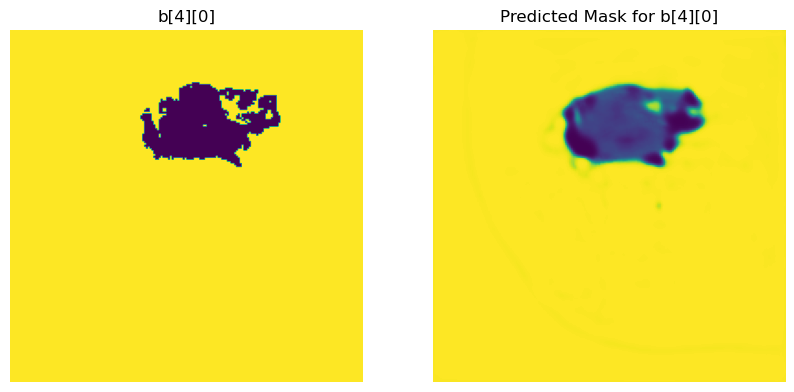

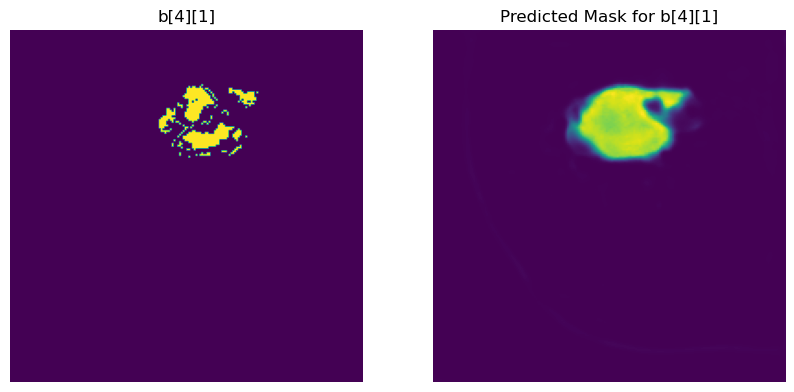

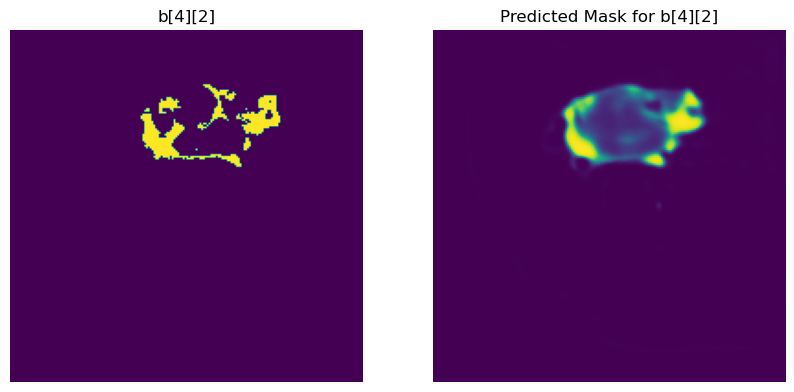

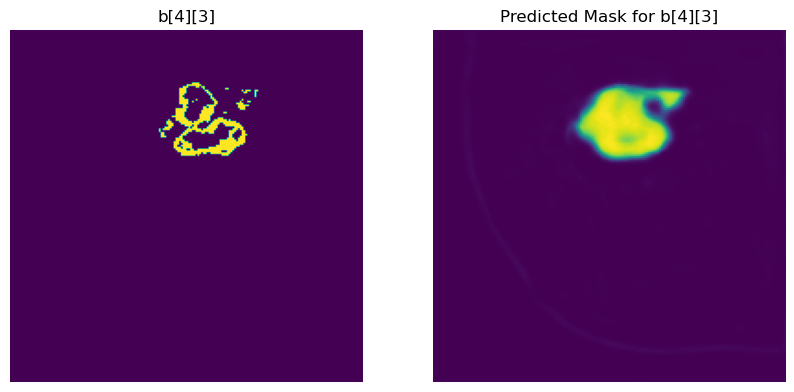

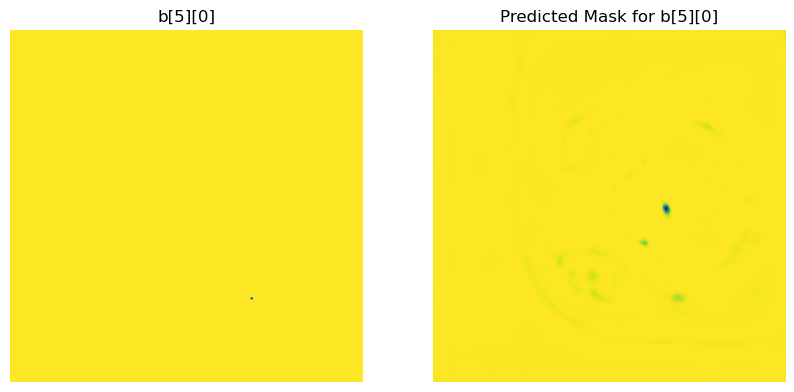

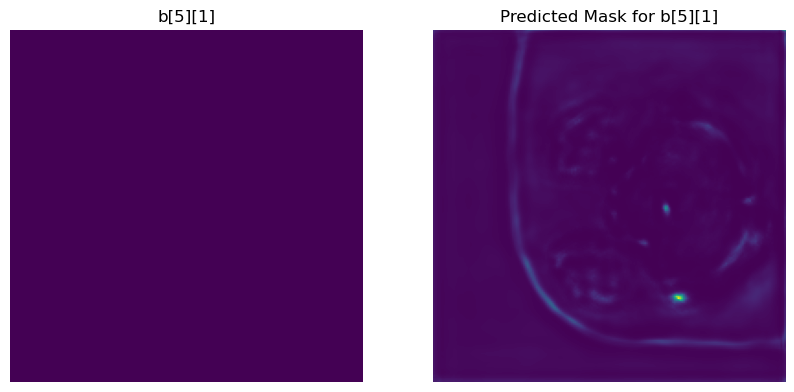

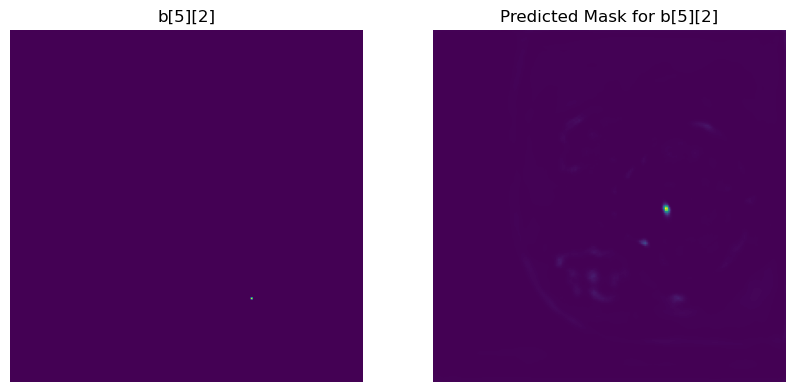

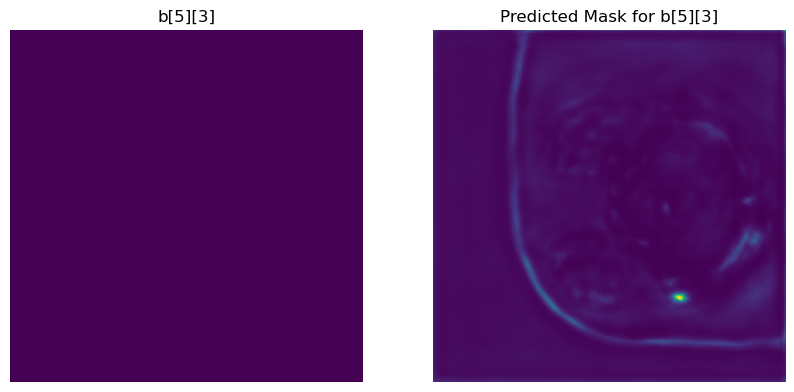

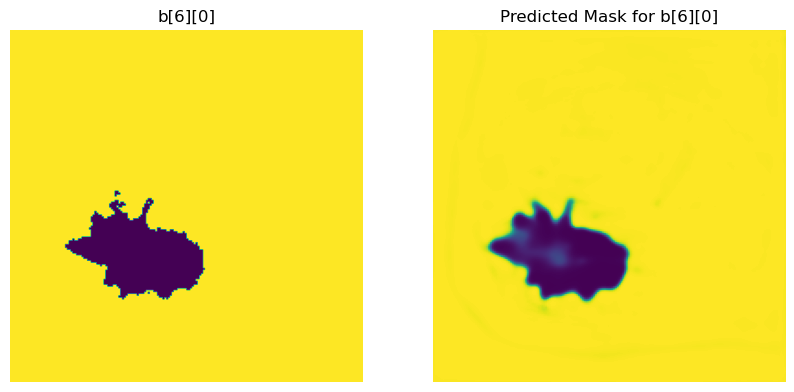

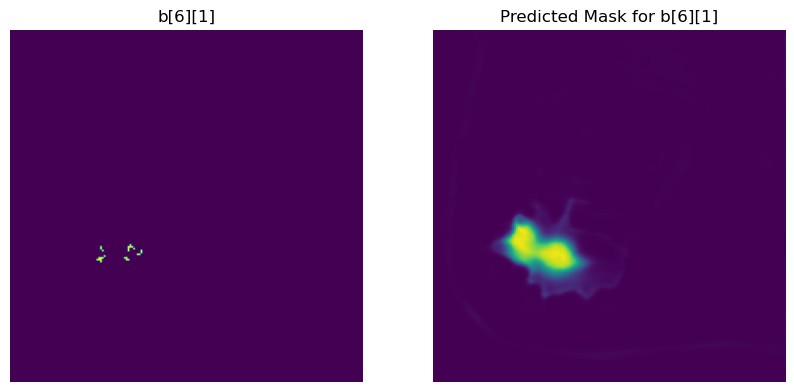

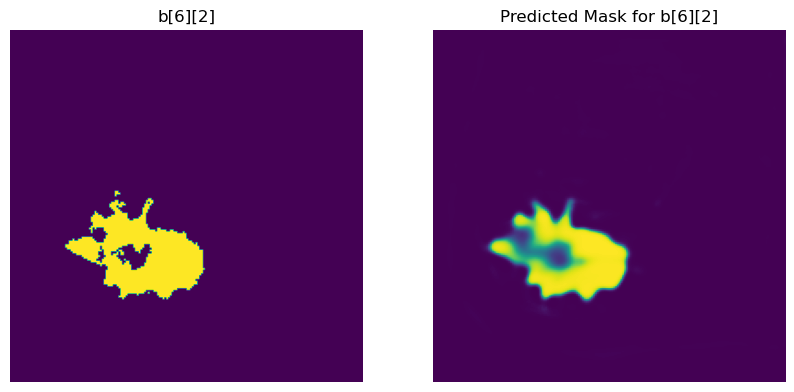

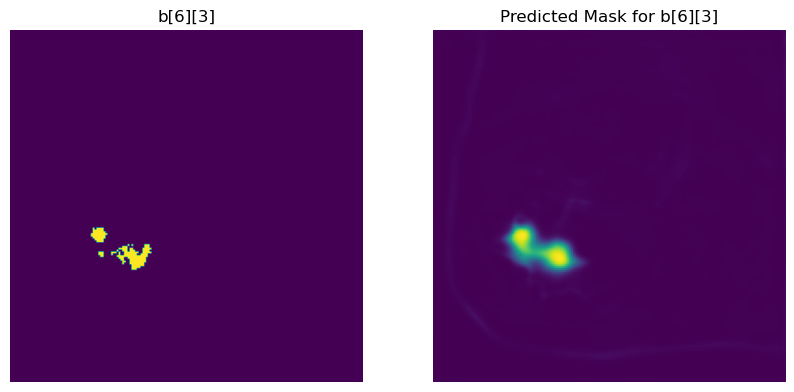

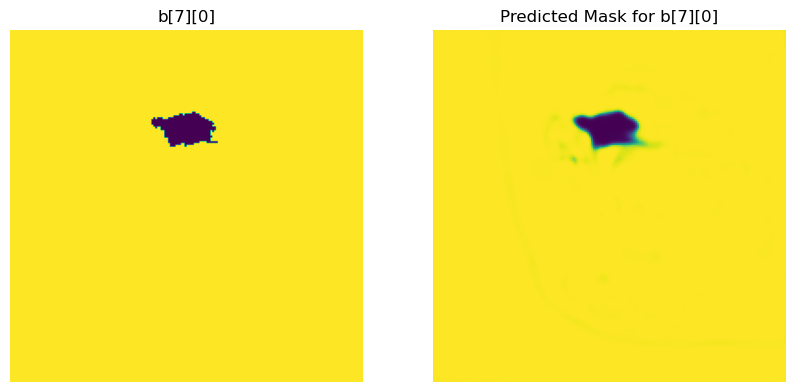

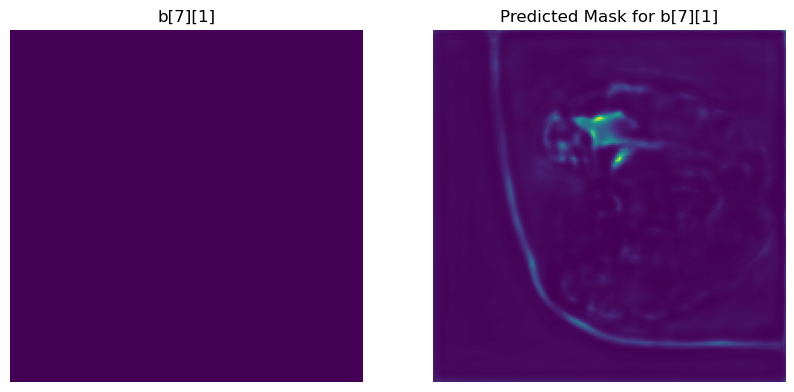

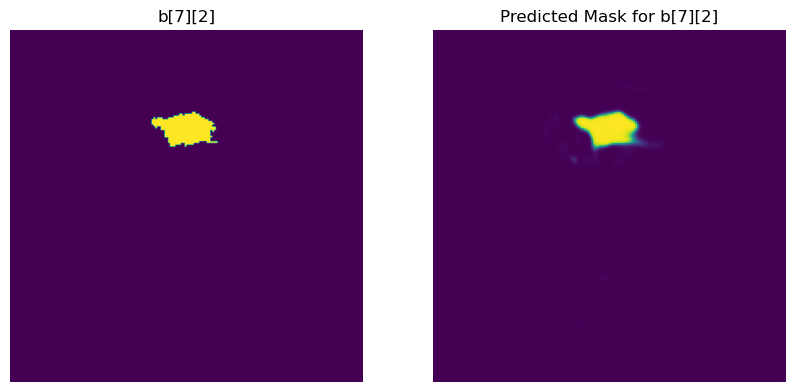

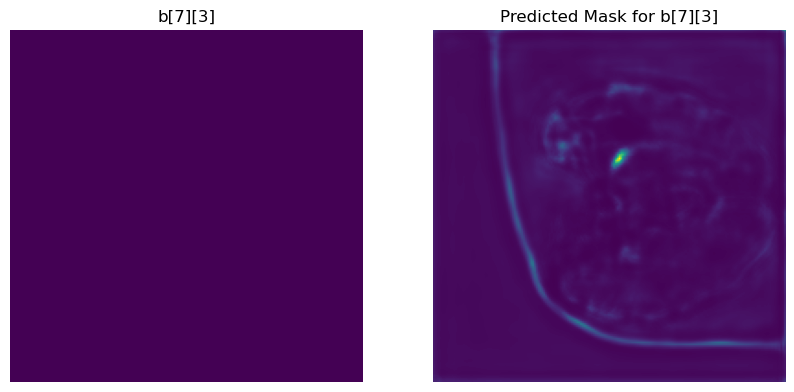

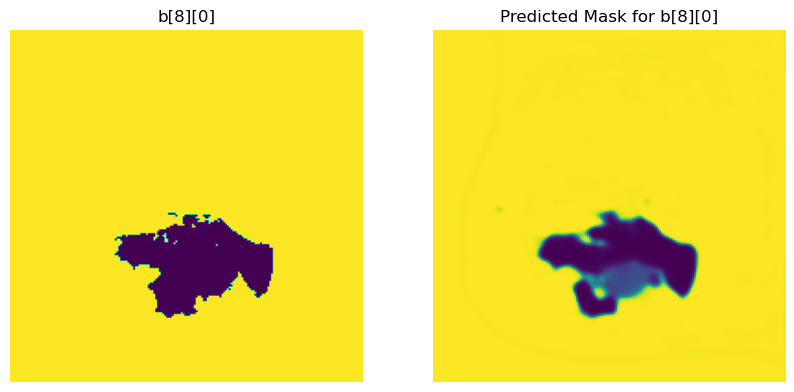

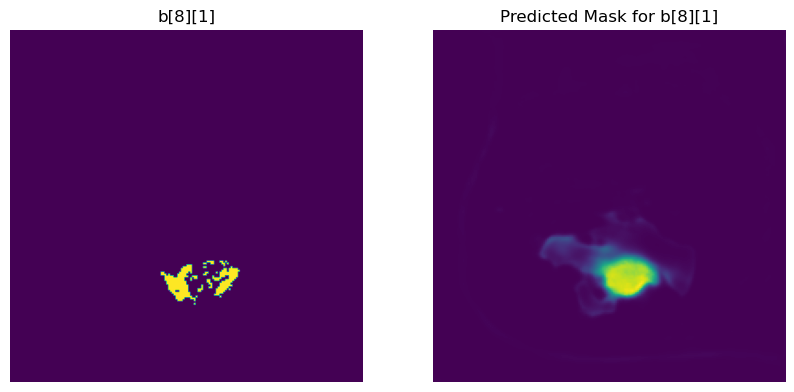

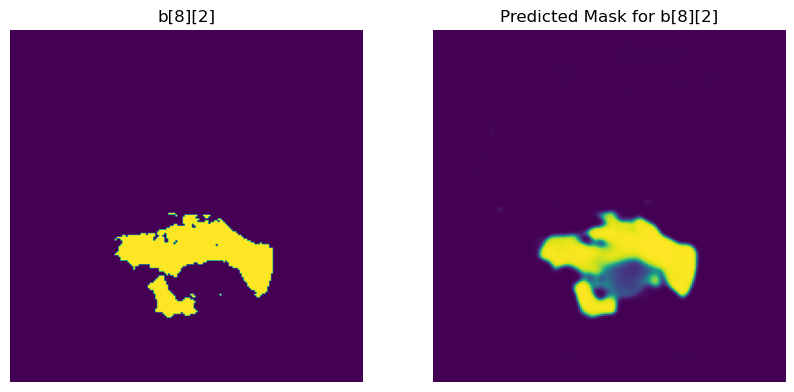

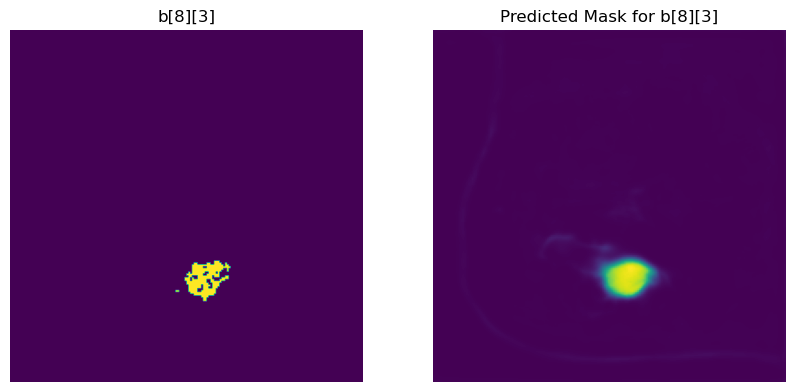

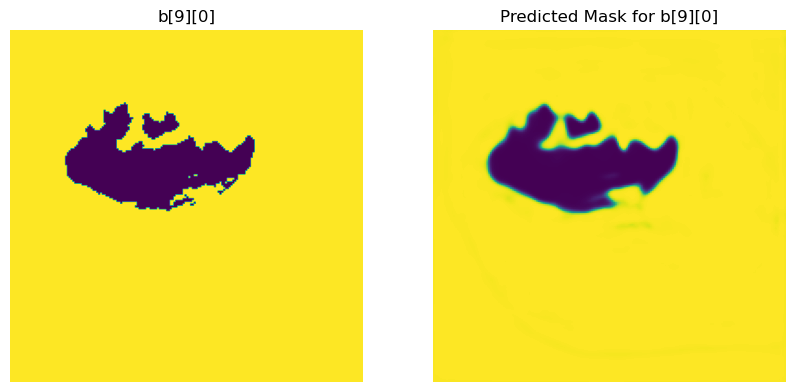

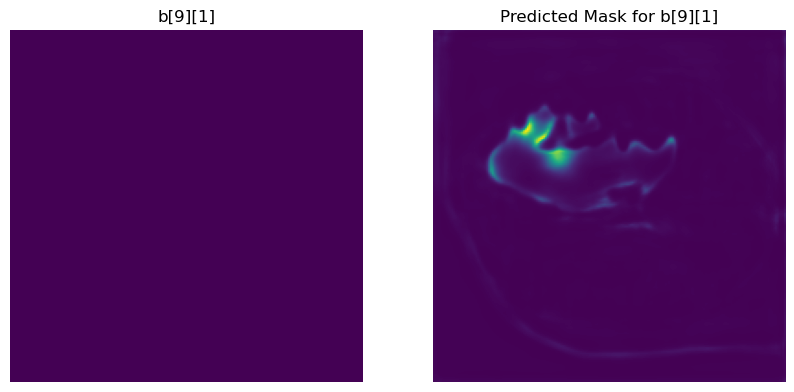

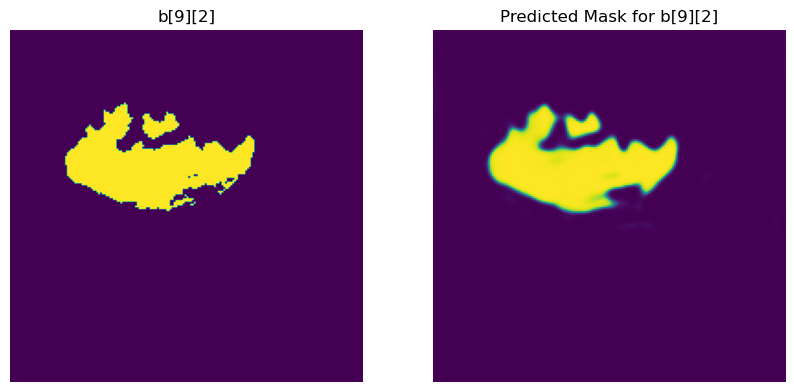

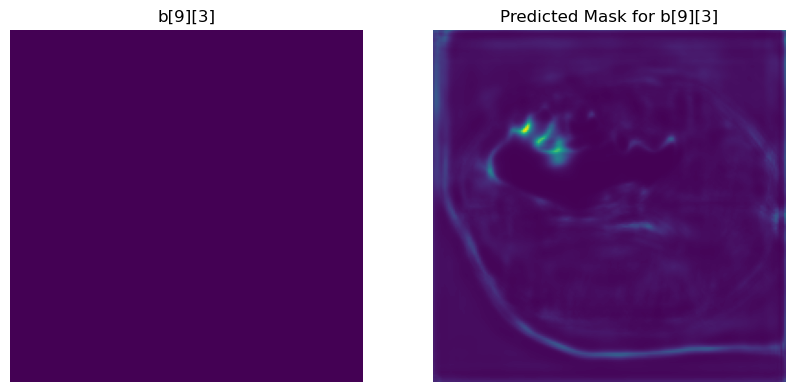

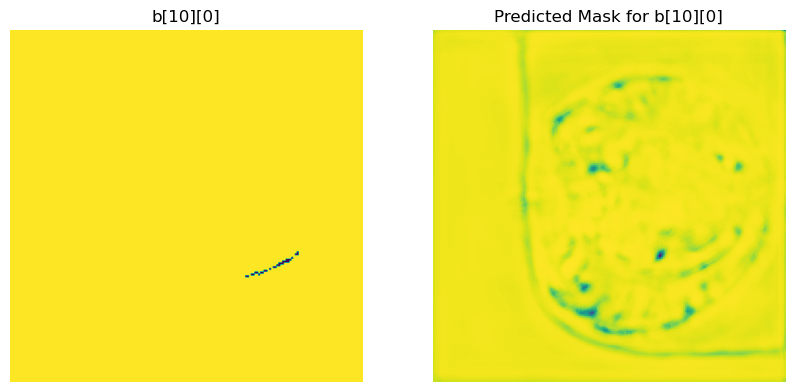

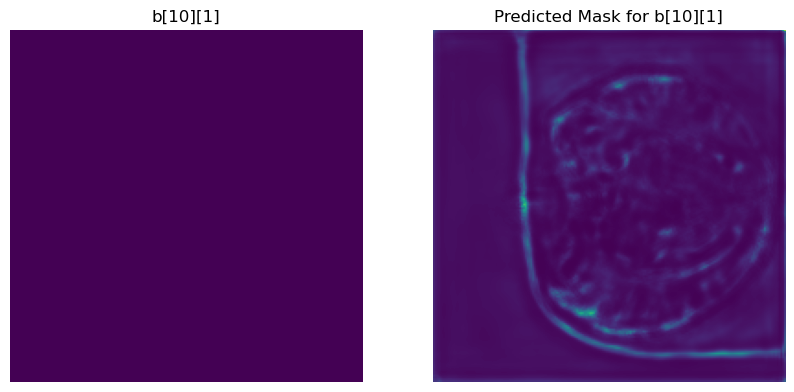

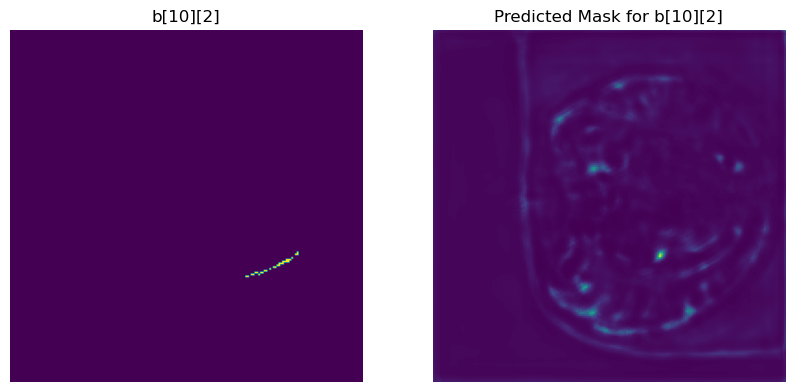

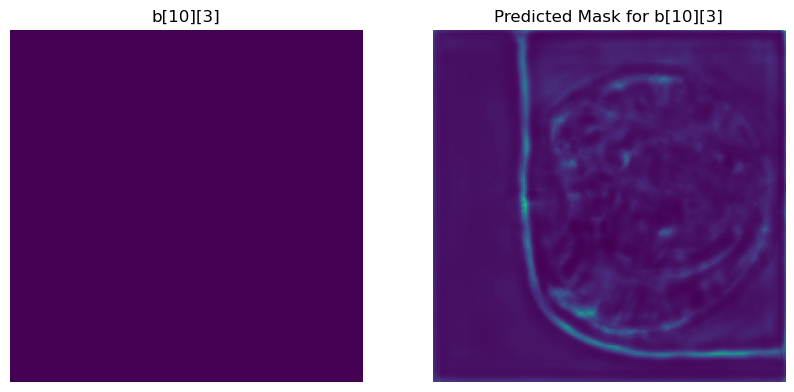

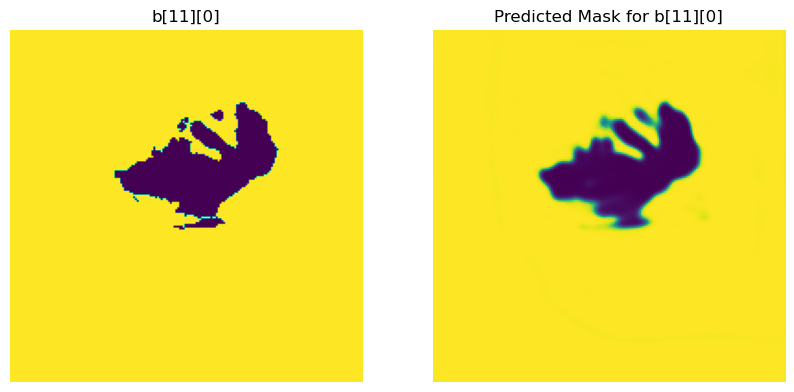

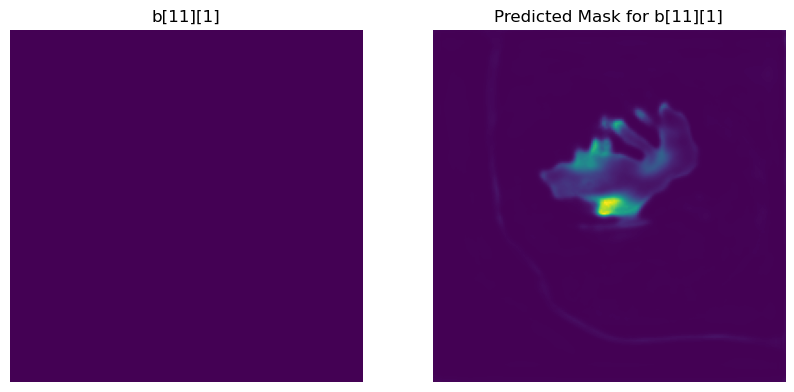

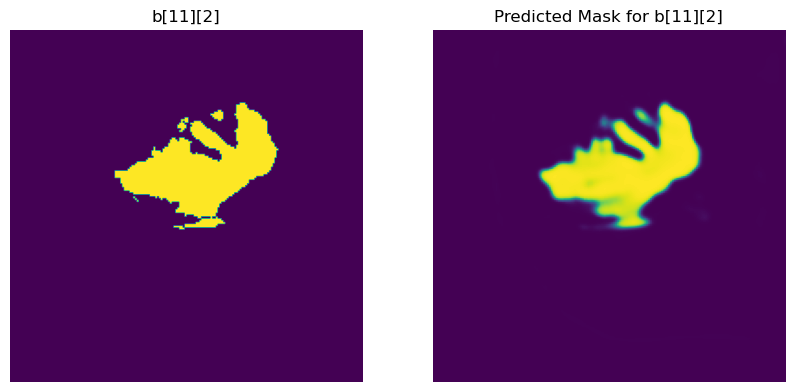

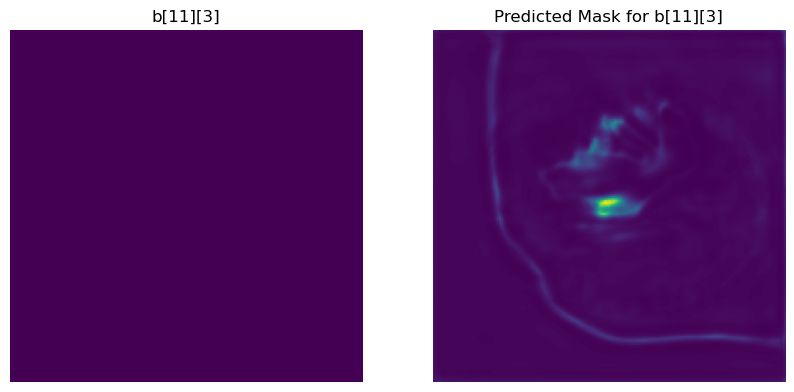

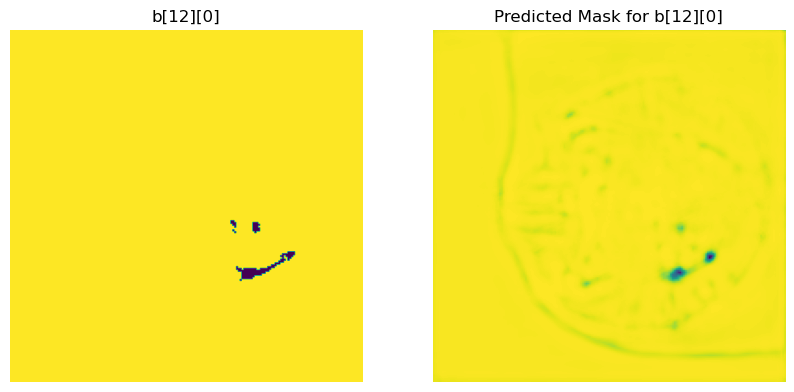

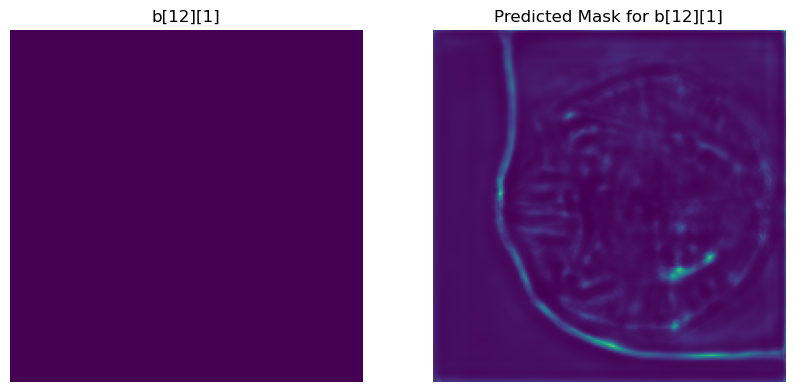

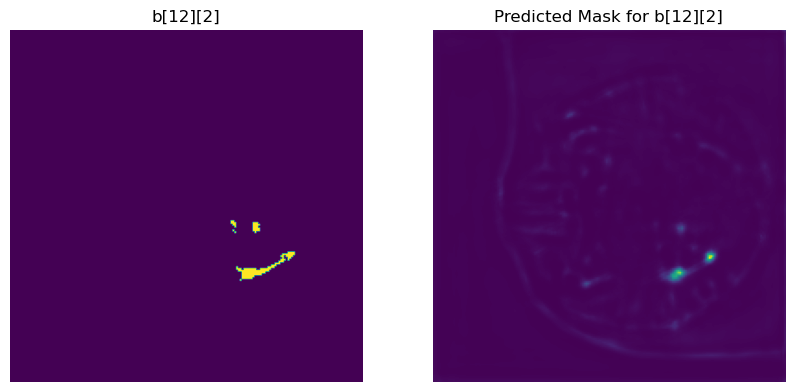

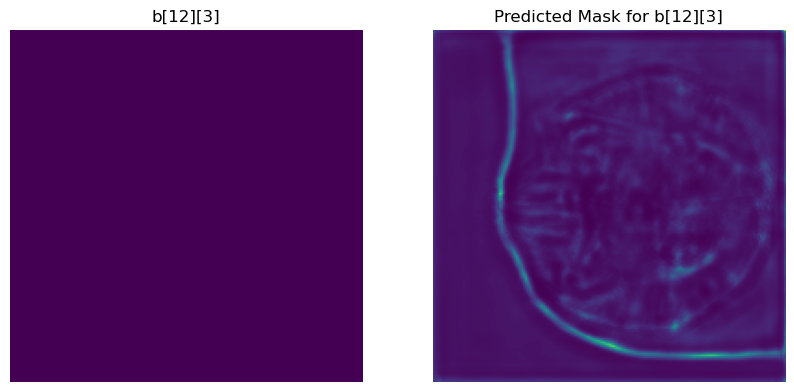

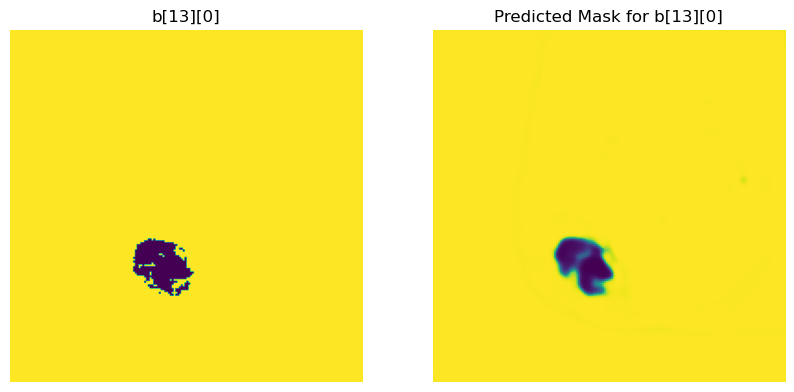

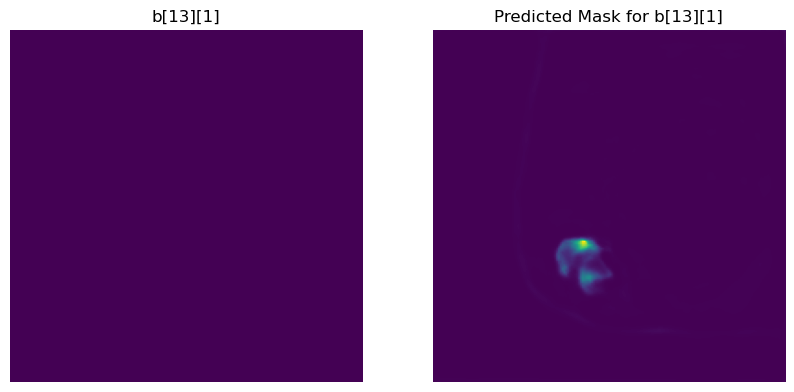

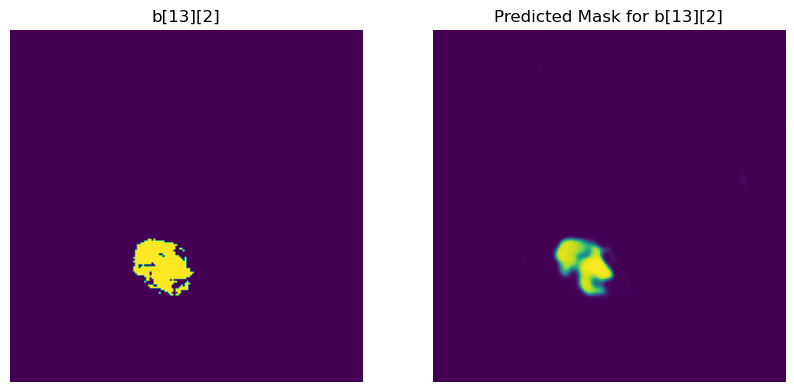

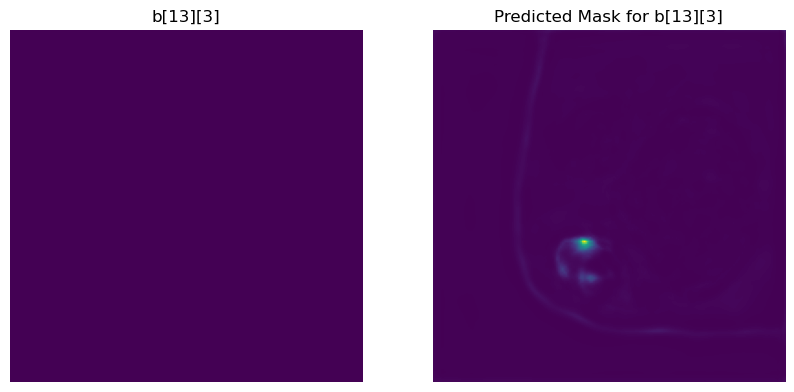

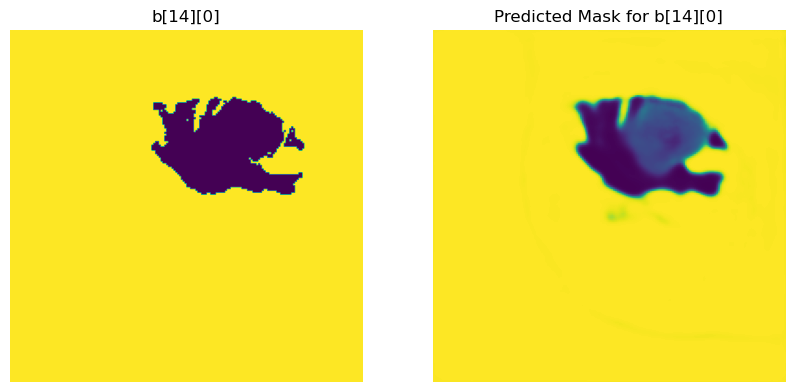

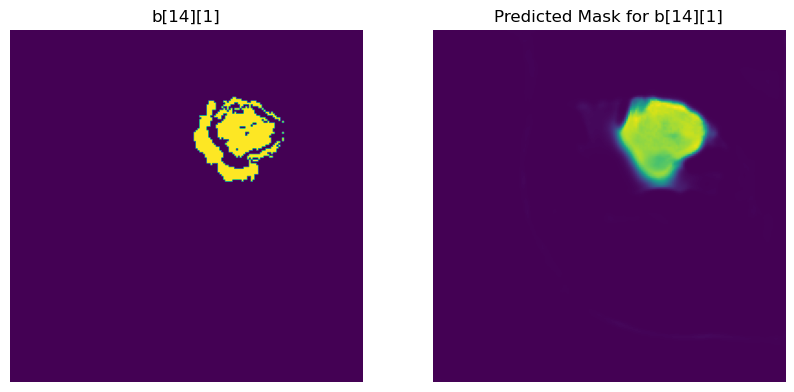

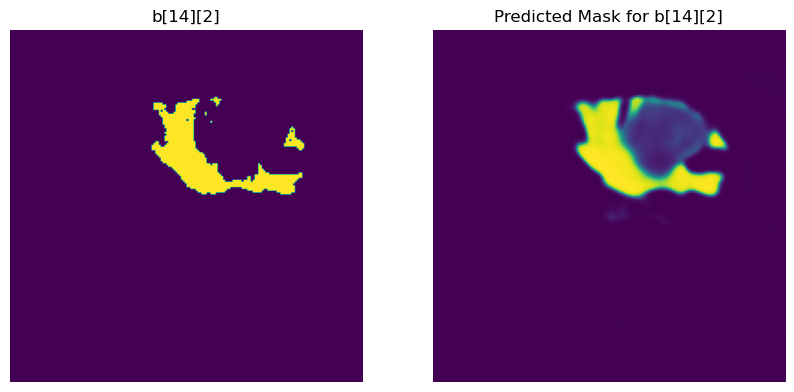

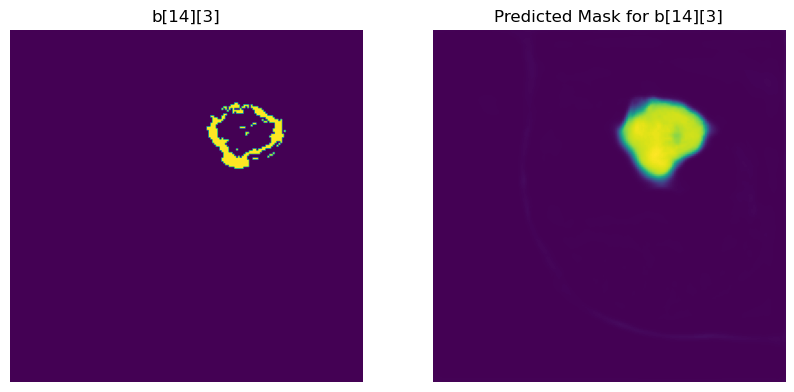

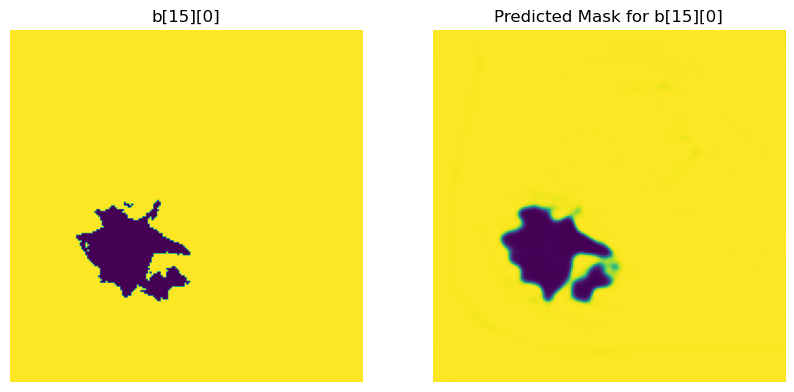

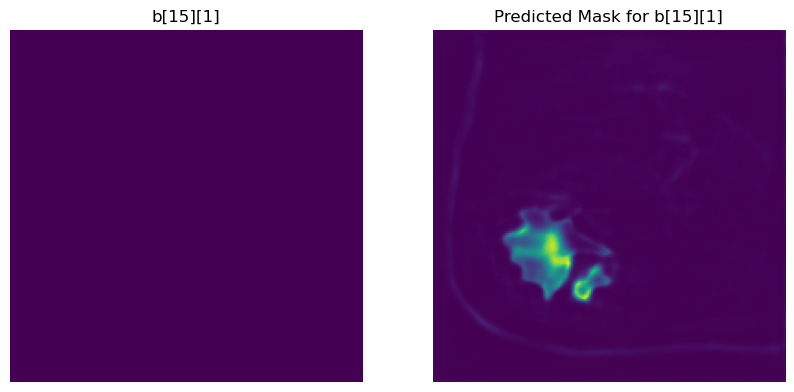

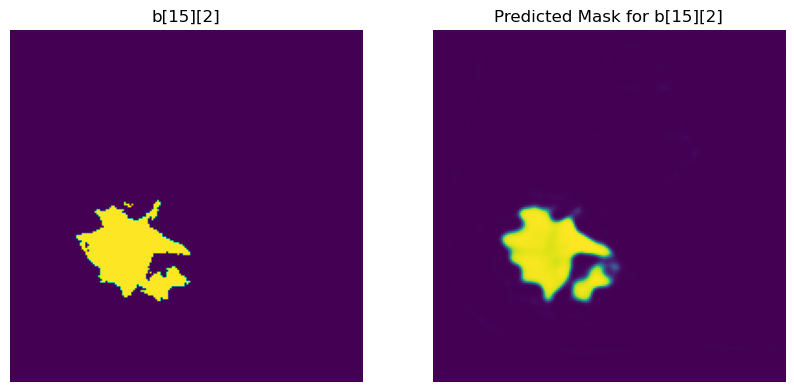

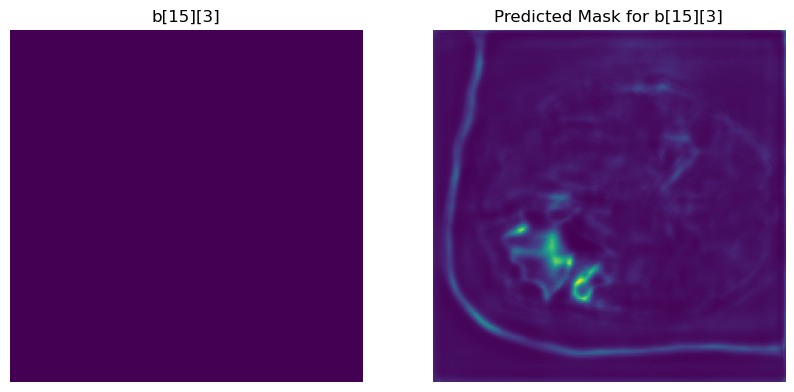

In [32]:
for i in range(len(b)):
    for j in range(len(b[i])):
        plt.figure(figsize=(10, 5))

        # Plot b[i][j]
        plt.subplot(1, 2, 1)
        plt.imshow(b[i][j])
        plt.title(f"b[{i}][{j}]")
        plt.axis('off')

        # Plot predicted_mask_cpu[i][j]
        plt.subplot(1, 2, 2)
        plt.imshow(predicted_mask_cpu[i][j])
        plt.title(f"Predicted Mask for b[{i}][{j}]")
        plt.axis('off')

        plt.show()
